In [1]:
#load packages
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library(dplyr)

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#All text should be sans-serif typeface,
#preferably Helvetica or Arial.
#Maximum text size is 7pt. Minimum text size is 5pt.
#max width 6.88976

In [3]:
# Read in the 16S qza files 
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
# Extract the count data from list
ASVtable_16S <- ASVtable_16S$data 
#Extract taxa 
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"))  %>% 
unite("Taxa", Order:Genus, remove = FALSE) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV)  
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#read metadata
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv", header = T, row.names = 1,
na.strings = c("", "NA"))


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [4]:
#arrange metadata factors

sample_info_tab_16S$sample_type <- factor(sample_info_tab_16S$sample_type, 
    levels = c("Seawater", "Mucus", "TissueSlurry", "TissueSlurry_Skeleton", "Sediment", "Control", "Mock"))

sample_info_tab_16S$sample_type <- factor(sample_info_tab_16S$sample_type, 
    levels = c("Seawater", "Mucus", "TissueSlurry", "TissueSlurry_Skeleton", "Sediment"))

sample_info_tab_16S$tissue_type <- factor(sample_info_tab_16S$tissue_type, 
    levels = c("AH", "DU", "DL"))

sample_info_tab_16S$SCTLD_status = factor(sample_info_tab_16S$SCTLD_status,
                                  c("Vulnerable", "Endemic", "Epidemic")) 

In [5]:
#make phyloseq object
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

In [6]:

#subset data
sub_samples = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment")


sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")

sub_samples3 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment", "Control", "Mock")

ps =subset_samples(physeq_16S, sample_type %in% sub_samples)
ps

ps3 =subset_samples(physeq_16S, sample_type %in% sub_samples3)
ps3

#filter low abundance 
ps = filter_taxa(ps, function(x) sum(x > 20) > (0.015*length(x)), TRUE)
ps
  

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2972 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 2972 taxa by 10 taxonomic ranks ]

## Figure 1

In [7]:
#make long format
sum_ps   <- ps  %>%
  tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


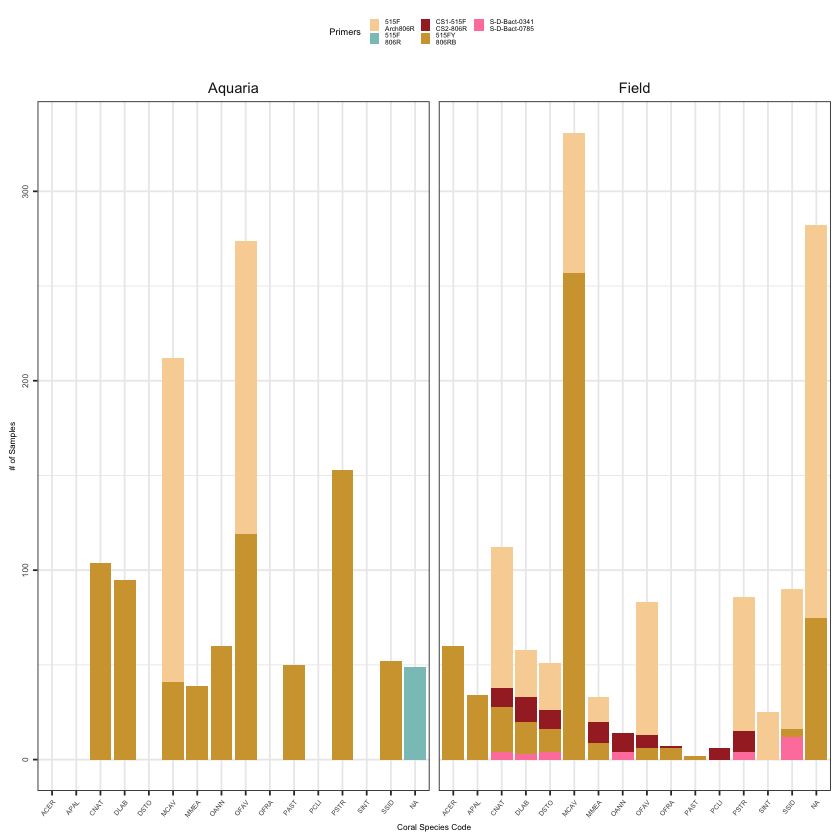

In [8]:
primer_samples = sample_data(ps) %>%
as.tibble  %>%

ggplot(
       aes(x =species_code)) + 
geom_bar(aes(fill=primer_names)) +
theme_bw() +
xlab("Coral Species Code") +
 labs(fill = "Primers") +
ylab("# of Samples") +
facet_wrap(~Biome) +
theme(strip.background = element_blank()) +
theme(axis.title.x = element_text(size = 5),
      axis.title.y = element_text(size = 5),
       axis.text.y = element_text(size =5, angle = 90, hjust = 0.5),
      axis.text.x = element_text(size =4, angle = 50, hjust = 1)) +
guides(fill = guide_legend(keywidth = 0.5, keyheight =.50, nrow=2)) +
theme(legend.position="top",
legend.text =element_text(size=4),
legend.title = element_text(size=5.5)) +
scale_fill_manual(values=c("#F9D4A4",  "#89C4C2","brown", "#D1A33D","palevioletred1","lightblue4"),
                
                   labels=c(CS1_515F_CS2_806R="CS1-515F\nCS2-806R",
                         Pr515_806RAp="515FY\n806RB",
                         S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21="S-D-Bact-0341\nS-D-Bact-0785",
                        Caporaso515F_806RCaporaso="515F\n806R",
                         AA515F_archaea806R="515F\nArch806R"))


primer_samples

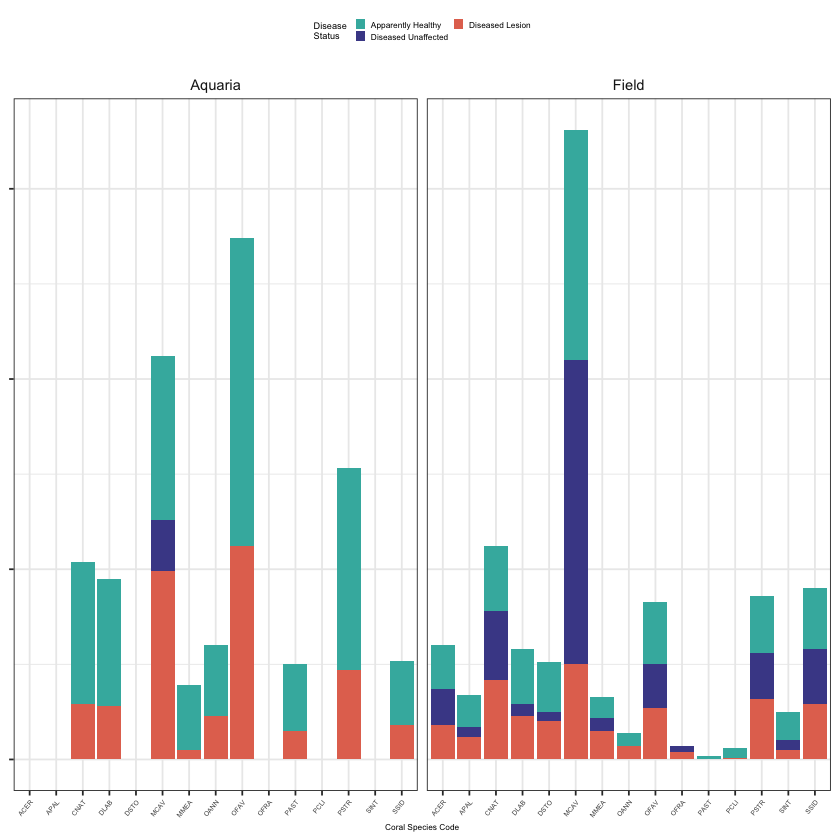

In [9]:
health_samples = sample_data(ps) %>%
as.tibble  %>%
filter(tissue_type!="NA") %>%

ggplot(
       aes(x =species_code)) + 
geom_bar(aes(fill=tissue_type)) +
scale_fill_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme_bw() +
guides(fill = guide_legend(keywidth = 0.5, keyheight =.50, nrow=2)) +
xlab("Coral Species Code") +
 labs(fill = "Disease\nStatus") +
ylab("# of Samples") +
facet_wrap(~Biome) +
theme(strip.background = element_blank()) +
theme(axis.title.x = element_text(size = 5), 
      axis.title.y = element_blank(),
      axis.text.x = element_text(size =4, angle = 50, hjust = 1),
      axis.text.y = element_blank()) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=5.5),
     legend.position="top") 

health_samples

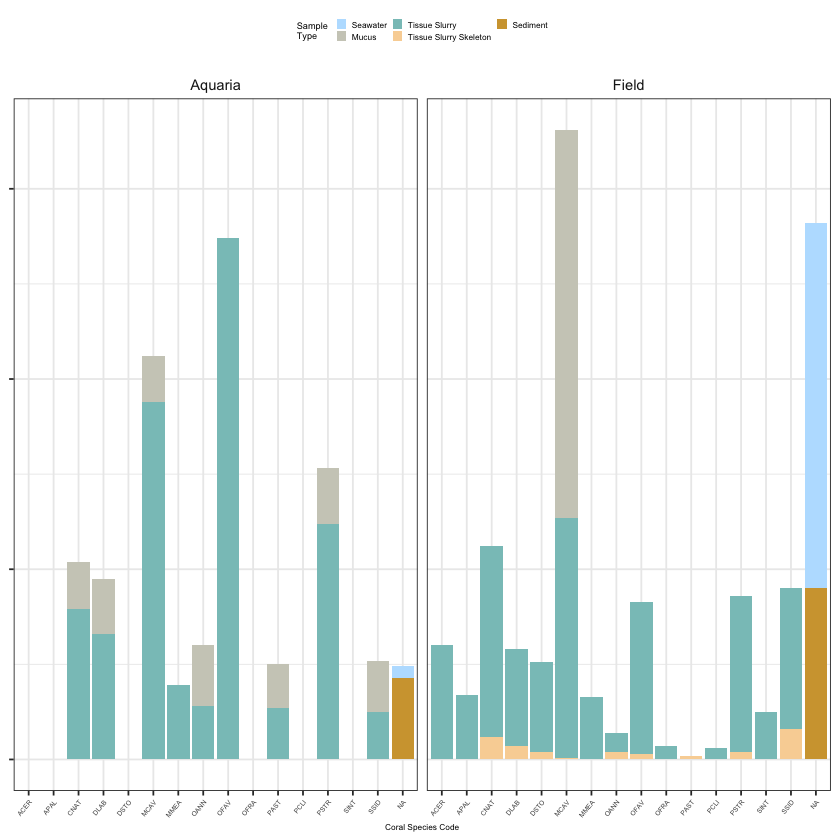

In [10]:
types_samples= sample_data(ps) %>%
as.tibble  %>%

ggplot(
       aes(x =species_code)) + 
geom_bar(aes(fill=sample_type)) +
scale_fill_manual(values=c("#bae1ff","ivory3", "#89C4C2", "#F9D4A4" , "#D1A33D"),
                 label=c(TissueSlurry_Skeleton= "Tissue Slurry Skeleton",
                        TissueSlurry="Tissue Slurry")) +
theme_bw() +
guides(fill = guide_legend(keywidth = 0.5, keyheight =.50, nrow=2)) +
theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
theme(legend.position="top") +
xlab("Coral Species Code") +
 labs(fill = "Sample\nType") +
facet_wrap(~Biome) +
theme(strip.background = element_blank()) +
theme(axis.title.x = element_text(size = 5), 
      axis.title.y = element_blank(),
      axis.text.x = element_text(size =4),
      axis.text.y = element_blank()) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=5.5))
types_samples

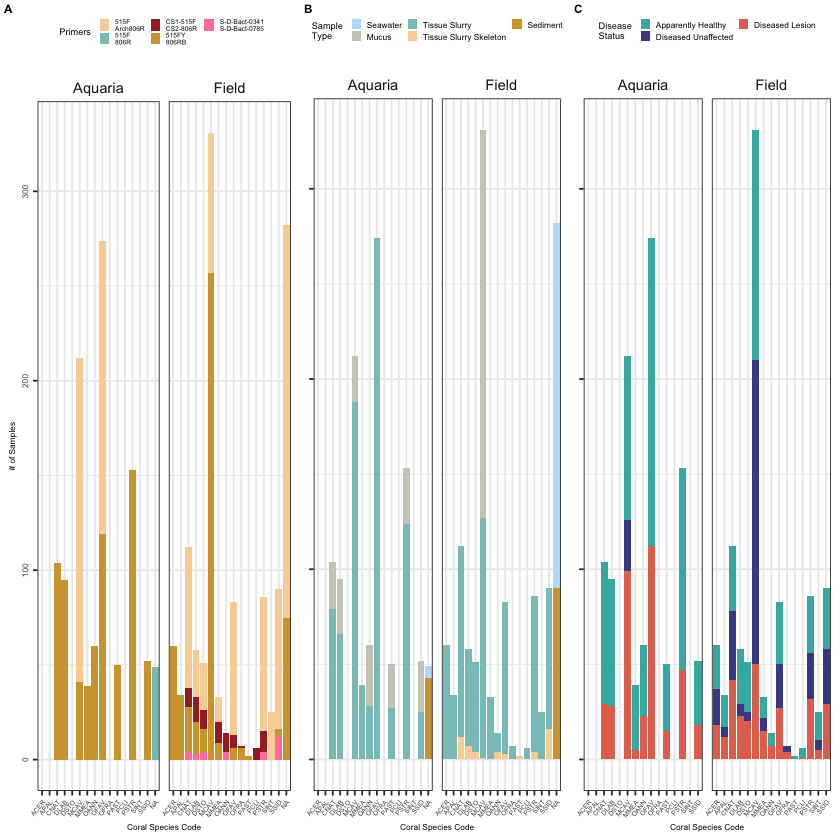

In [11]:
ggpubr::ggarrange(primer_samples, types_samples, health_samples, labels = c("A", "B", "C"),
                 font.label = list(size = 7, color = "black"), nrow=1,
                 widths = c(1,0.9,0.9))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure1.pdf",
     width = 6.87, height = 4, units = "in", dpi=300)

## Figure 2

In [12]:
#library 
library(ANCOMBC)

In [13]:
#subset samples

sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")


ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples2 & Alias!="AcroporaDisease"
                       )

ps.coral


ps.coral_TL_reef =subset_samples(ps.coral, Biome=="Field")
ps.coral_TL_reef

ps.coral_TL_reef =subset_samples(ps.coral_TL_reef, tissue_type=="AH" )
ps.coral_TL_reef


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 345 samples ]
sample_data() Sample Data:       [ 345 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

In [14]:
#filter data
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral
  
ps.coral_TL_reef = filter_taxa(ps.coral_TL_reef, function(x) sum(x > 5 ) > (0.20*length(x)), TRUE)
ps.coral_TL_reef

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 204 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 204 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 264 taxa and 345 samples ]
sample_data() Sample Data:       [ 345 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 264 taxa by 10 taxonomic ranks ]

In [15]:
out = ancombc(phyloseq = ps.coral_TL_reef, formula = "SCTLD_status", 
              p_adj_method = "fdr", zero_cut = 0.90, lib_cut = 100, 
              group ="SCTLD_status" , struc_zero = TRUE, neg_lb = FALSE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.001, global = TRUE)

res = out$res
res_global = out$res_global

In [16]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")

df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")

df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, SCTLD_statusEpidemic, SCTLD_statusEpidemicSD)%>%
  mutate(group = ifelse(SCTLD_statusEpidemic > 0, "Epidemic", "Vulnerable"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)

sigs=res$diff_abn %>% as.data.frame() %>%
select(SCTLD_statusEpidemic)  %>%
filter(SCTLD_statusEpidemic=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=SCTLD_statusEpidemic)



df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)


df_fig_epi = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% 
filter(SCTLD_statusEpidemic > 2 | SCTLD_statusEpidemic < -2)  %>% 
unite("Taxa", Order:Genus, remove = FALSE) #%>%
#mutate(Compartment = "Tissue Slurry\nSkeleton")



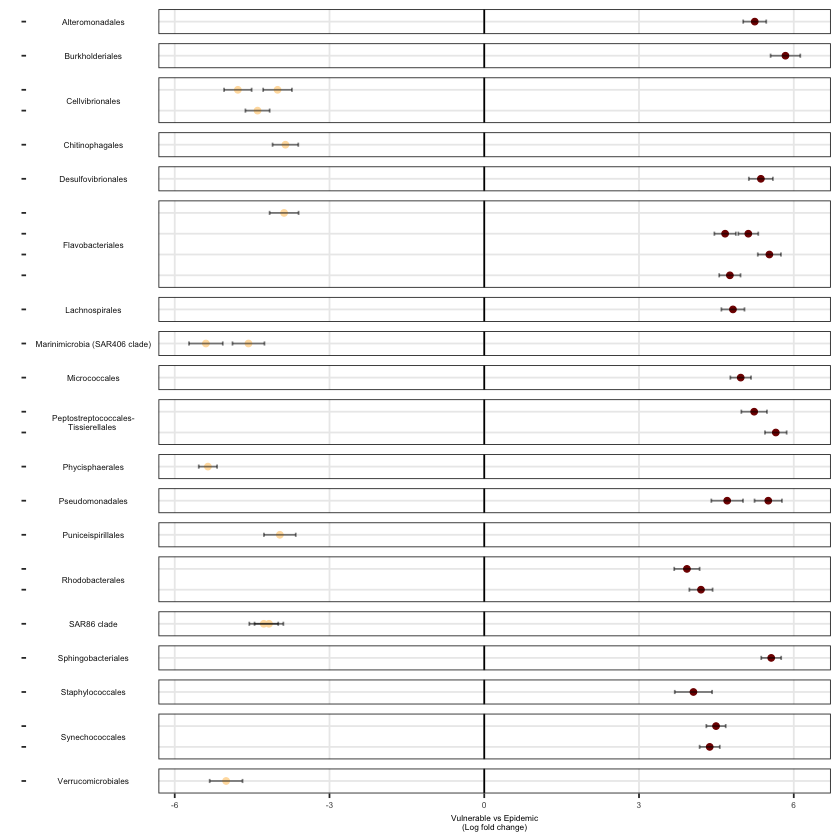

In [17]:
fig_sigs_epi = as.data.frame(df_fig_epi) %>%
#filter(SCTLD_statusEpidemic > 1.5 | SCTLD_statusEpidemic < -1.5) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%

ggplot( 
           aes(SCTLD_statusEpidemic, y = Genus)
              ) + 
geom_point(aes(color=group)) +

  theme_bw() + 
 theme(legend.position = "none",
       panel.grid.minor.x = element_blank()) +
  
geom_errorbar(aes(xmin = SCTLD_statusEpidemic - SCTLD_statusEpidemicSD, xmax = SCTLD_statusEpidemic + SCTLD_statusEpidemicSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
 labs(y = "", x = "Vulnerable vs Epidemic\n(Log fold change)") + 
scale_color_manual(values=c(
  "#800000",  "#FFDEAD"
)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_blank()) +
theme(axis.text.x = element_text(size =5)) +
theme(strip.text.y = element_blank()) +
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
theme(strip.text.y = element_text(size = 5)) +
geom_vline(xintercept = 0,  
                color = "black", size=.5)
fig_sigs_epi


In [18]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")

df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")

df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, SCTLD_statusEndemic, SCTLD_statusEndemicSD)%>%
  mutate(group = ifelse(SCTLD_statusEndemic > 0, "Endemic", "Vulnerable"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)

sigs=res$diff_abn %>% as.data.frame() %>%
select(SCTLD_statusEndemic)  %>%
filter(SCTLD_statusEndemic=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=SCTLD_statusEndemic)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)

df_fig_end = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% 
filter(SCTLD_statusEndemic > 2 | SCTLD_statusEndemic < -2)  %>% 
unite("Taxa", Order:Genus, remove = FALSE) 

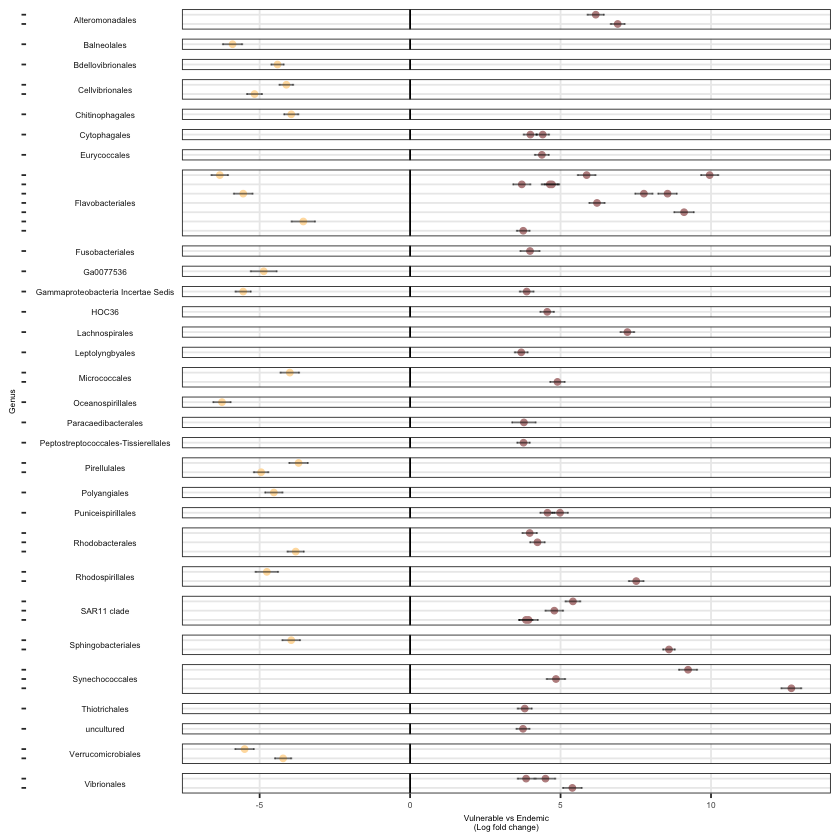

In [19]:
fig_sigs_end = as.data.frame(df_fig_end) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%

ggplot( 
           aes(SCTLD_statusEndemic, y = Genus)
              ) + 
geom_point(aes(color=group)) +
 theme(legend.position = "none",
    panel.grid.minor.x = element_blank()) +
  theme_bw() + 

  
geom_errorbar(aes(xmin = SCTLD_statusEndemic - SCTLD_statusEndemicSD, xmax = SCTLD_statusEndemic + SCTLD_statusEndemicSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
 labs(y = "Genus", x = "Vulnerable vs Endemic\n(Log fold change)") + 
scale_color_manual(values=c(
 "#BC8F8F", "#FFDEAD"
)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_blank()) +
theme(axis.text.x = element_text(size =5)) +
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
theme(strip.text.y = element_text(size = 5)) +
geom_vline(xintercept = 0,  
                color = "black", size=.5) +
 theme(legend.position = "none",
    panel.grid.minor.x = element_blank())
fig_sigs_end


In [20]:
ps.coral_TL_reef_CLR <- microbiome::transform(ps.coral_TL_reef, 'clr')
ps.coral_TL_reef_ord <- ordinate(ps.coral_TL_reef_CLR, "RDA", "euclidean")

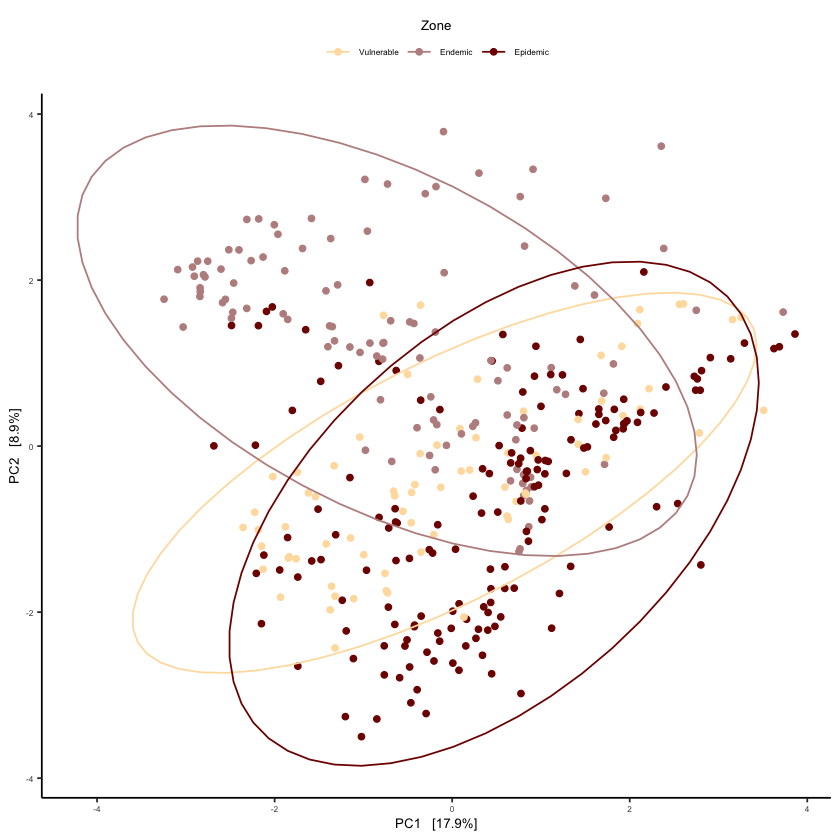

In [21]:
fig_ord_zone =plot_ordination(ps.coral_TL_reef_CLR, ps.coral_TL_reef_ord,
                               color="SCTLD_status",
                            #shape="Location",
                               axes = c(1,2)) +

theme_classic() +
scale_color_manual(values=c("#FFDEAD","#BC8F8F", "#800000")) +
scale_shape_manual(values=c(16, 17),
                  label=c(VirginIslands="Virgin Islands")) +
stat_ellipse() +
theme_classic() +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 8)) +
theme(axis.title.y = element_text(size = 8)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
labs(color='Zone',
    shape="Location") +
 theme(legend.position = "top", legend.box="vertical") +
guides(color=guide_legend(nrow=3),
      title.position = "None"
      ) +

guides(shape=guide_legend(ncol=3),
      title.position = "top") +
  guides(color = guide_legend(title.position = "top", 
                              title.hjust = 0.5)) +
  guides(shape = guide_legend(title.position = "top", 
                              title.hjust = 0.5))




#panel.grid.minor.x = element_blank())
fig_ord_zone

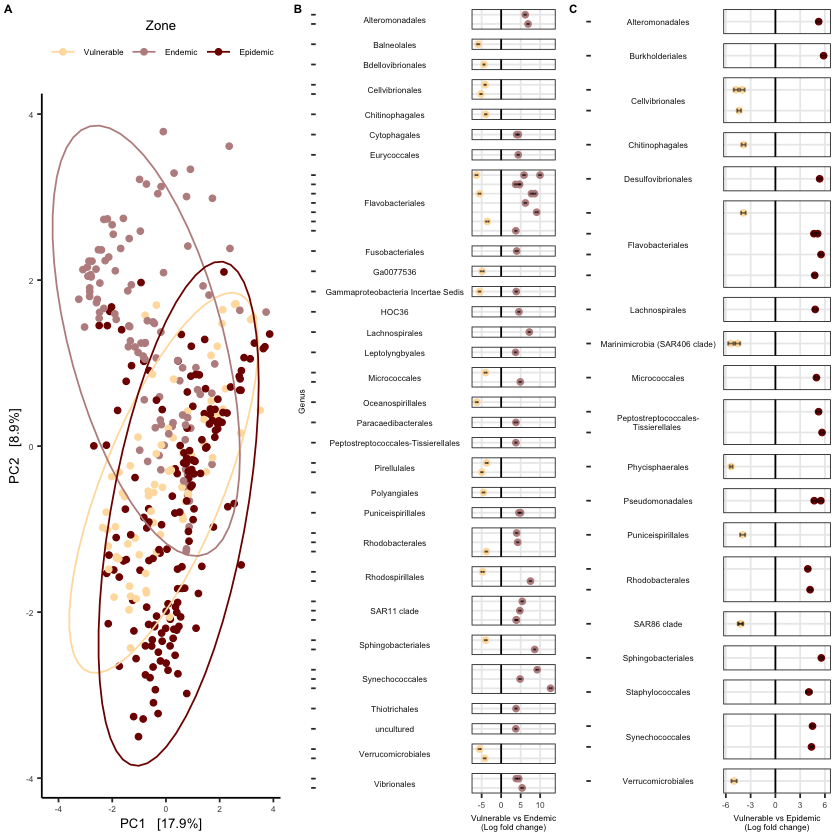

In [22]:
ggpubr::ggarrange(fig_ord_zone, fig_sigs_end, fig_sigs_epi, labels = c("A", "B", "C"),
                  common.legend = FALSE, 
                  font.label = list(size = 7, color = "black"), ncol =3,
                 widths = c(1, .95, .95))

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure2.pdf",
     width = 6.8, height = 6.0, units = "in", dpi=300)

## Supplemental Fig 2

In [23]:



ps_sigs_epi=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_epi) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
ps_sigs_epi

ps_sigs_end=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_end) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
ps_sigs_end

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 31 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 31 taxa by 14 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 61 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 61 taxa by 14 taxonomic ranks ]

In [24]:
ps_zones_sig=merge_phyloseq(ps_sigs_epi,ps_sigs_end)
ps_zones_sig
ps_zones_sig =subset_samples(ps_zones_sig, Biome=="Field")
ps_zones_sig


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 80 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 80 taxa by 16 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 80 taxa and 1277 samples ]
sample_data() Sample Data:       [ 1277 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 80 taxa by 16 taxonomic ranks ]

In [25]:
# agglomerate at Family level
sum_zones_sig  <- ps_zones_sig  %>%
  tax_glom(taxrank = "Order") %>%                     # agglomerate at Family level
 transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt() %>%                                         # Melt to long format
  arrange(Order) 


Warning message:
“Removed 252 rows containing missing values (position_stack).”
Warning message:
“Removed 252 rows containing missing values (position_stack).”


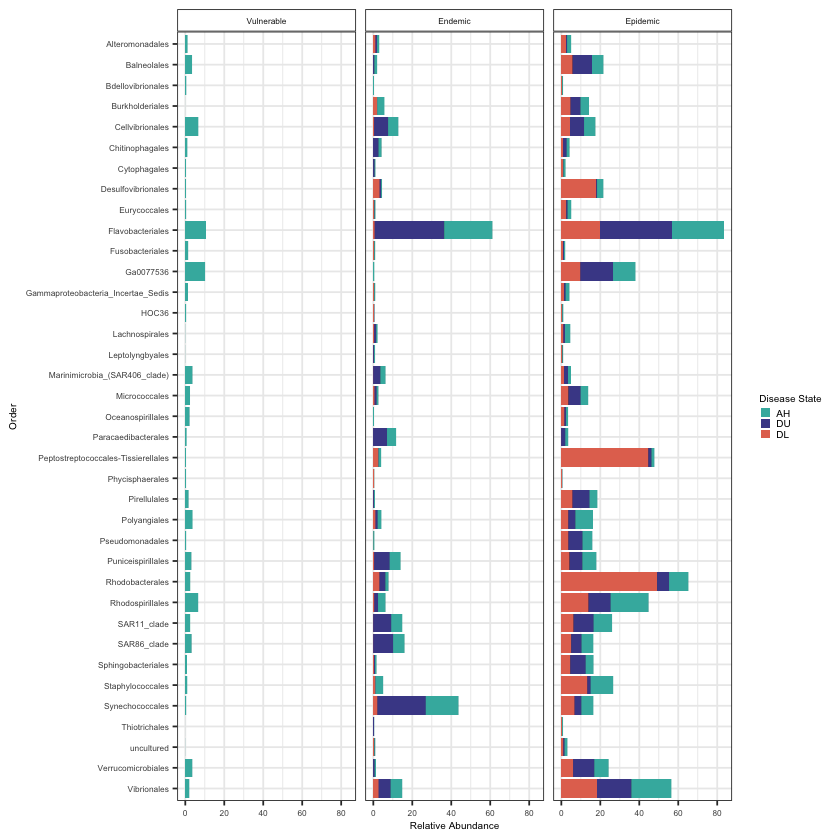

In [26]:
sum_zones_sig  %>%
#filter(Abundance >0.5) %>%
filter(SCTLD_status!="NA")%>%
filter(tissue_type!="NA")%>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

ggplot(
                   aes(x=reorder(Order, desc(Order)), y=Abundance, fill=tissue_type)) +
geom_bar(stat="identity", position="stack") +
coord_flip() +
facet_grid(.~SCTLD_status) +
scale_fill_manual(values=c("#40B5AD", "#4a4a96", "#E3735E")) +
ylab("Relative Abundance") + 
theme_bw() +
guides(fill = guide_legend(keywidth = 0.50, keyheight = 0.45, ncol=1)) +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.background = element_rect(fill="white")) +
xlab("Order") +
 labs(fill="Disease State")


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/SupplementalFig2.pdf",
     width = 5, height = 5.5, units = "in", dpi=300)

## Figure 3

In [27]:
#subset data
ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples
                    )
ps.coral


#filter data 
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 227 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 227 taxa by 10 taxonomic ranks ]

In [28]:
#transform data
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')
ps.coral_clr.ord <- ordinate(ps.coral_clr, "RDA", "euclidean")

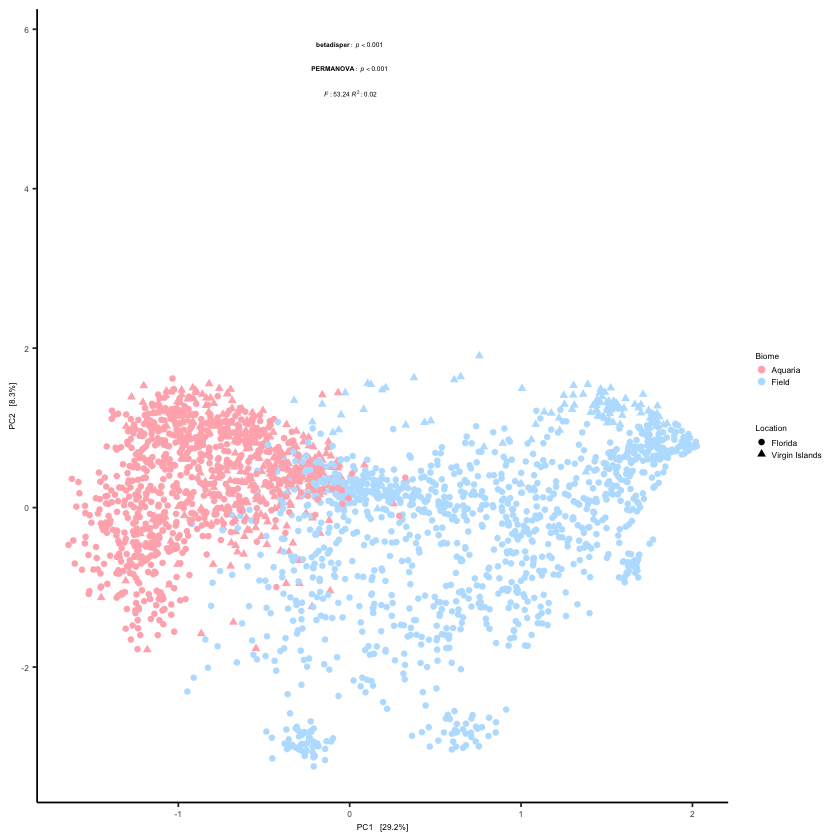

In [29]:
ord_biome = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Biome",
                              # shape="sample_type",
                              shape="Location",
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#ffb3ba", "#bae1ff")) +
scale_shape_manual(values=c(16, 17),
                  label=c(VirginIslands="Virgin Islands")) +

theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(legend.key.size = unit(.5, 'lines')) +
labs(shape='Location') +
annotate(geom="text", x=0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):53.24~italic(R^2):0.02",
           parse = TRUE, 
      
              color="black", size=1.4) 



#stat_ellipse()
ord_biome


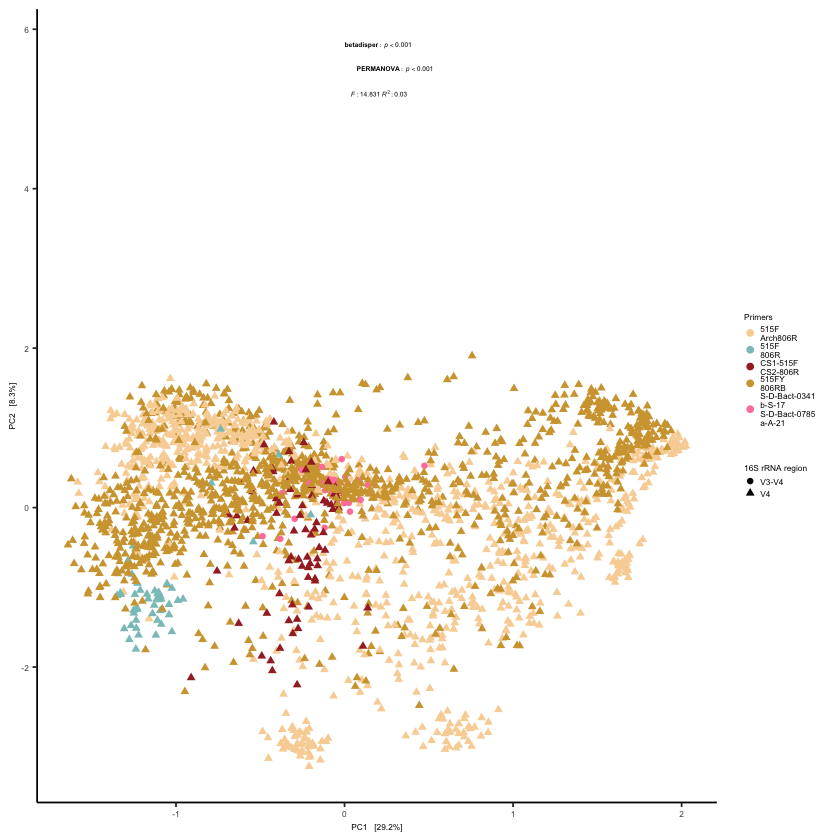

In [30]:
ord_primer= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="primer_names",
                              shape="X16S_variable_region",
                               axes = c(1,2)) +


theme_classic() +


scale_color_manual(values=c("#F9D4A4", 
                            "#89C4C2",
                           "brown", 
                           "#D1A33D",
                            "palevioletred1",
                           "lightblue4"),
                  
                  #labels=c(CS1_515F_CS2_806R="CS1-515F\nCS2-806R",
                        # Pr515_806RAp="515F (Parada)\n806R (Apprill)",
                         #S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21="S-D-Bact-0341-\nb-S-17\nS-D-Bact-0785-\na-A-21",
                        #Caporaso515F_806RCaporaso="515F (Caporaso)\n806R (Caporaso)",
                        #  AA515F_archaea806R="515F (Caporaso)\nArch806R")) +
                   
                        labels=c(CS1_515F_CS2_806R="CS1-515F\nCS2-806R",
                         Pr515_806RAp="515FY\n806RB",
                         S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21="S-D-Bact-0341\nb-S-17\nS-D-Bact-0785\na-A-21",
                        Caporaso515F_806RCaporaso="515F\n806R",
                         AA515F_archaea806R="515F\nArch806R")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(legend.key.size = unit(.5, 'lines')) +
labs(color='Primers', shape='16S rRNA region') +
annotate(geom="text", x=0.2, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.3, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.2, label = "~italic(F):14.831~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_primer


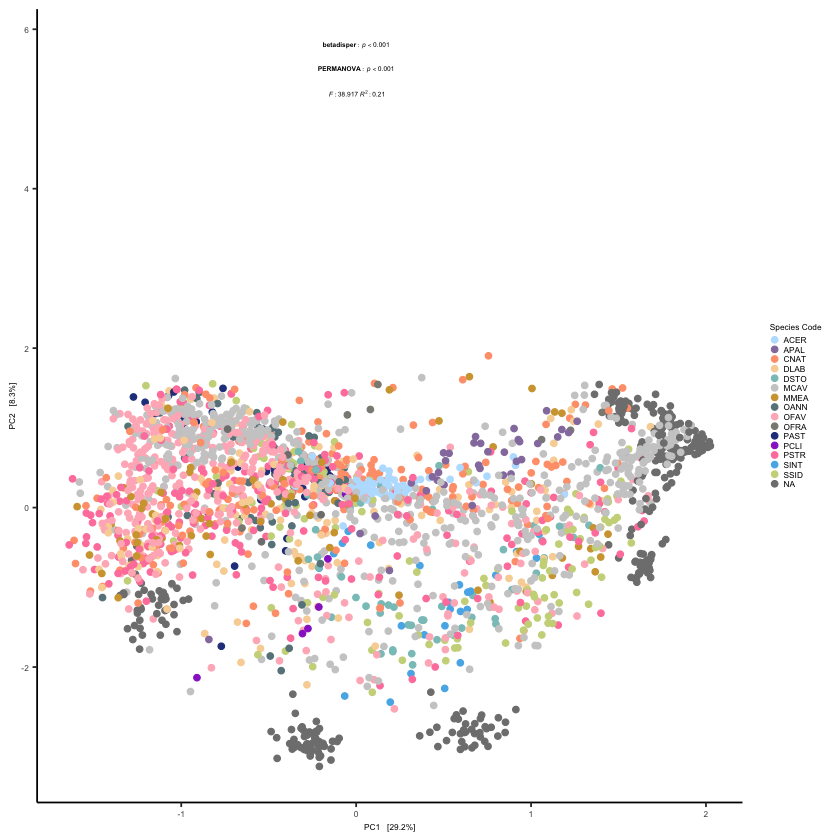

In [31]:
ord_species=plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="species_code",
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +
scale_shape_manual(values=c(1, 2),
                  label=c(VirginIslands="Virgin Islands")) +


theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
 theme(legend.key.size = unit(.4, 'lines')) +
labs(color='Species Code') +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):38.917~italic(R^2):0.21",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_species


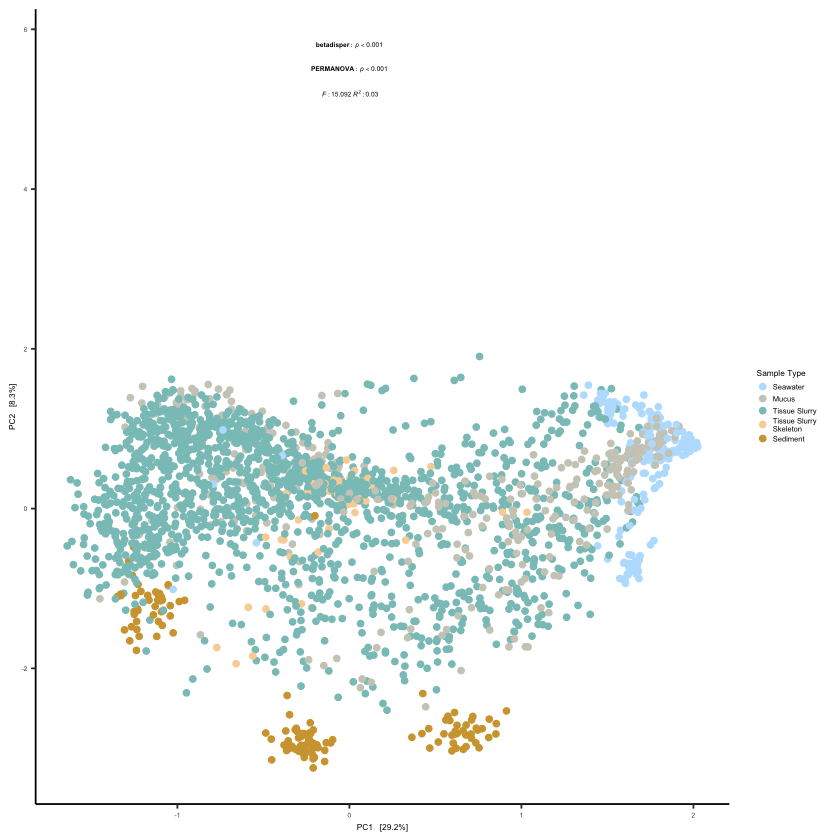

In [32]:
ord_type= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="sample_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=4.5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
theme(legend.key.size = unit(.5, 'lines')) +
labs(color='Sample Type') +

scale_color_manual(values=c("#bae1ff","ivory3", "#89C4C2",  "#F9D4A4" , "#D1A33D"), 
                  label=c(TissueSlurry_Skeleton= "Tissue Slurry\nSkeleton",
                        TissueSlurry= "Tissue Slurry" )) +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):15.092~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_type



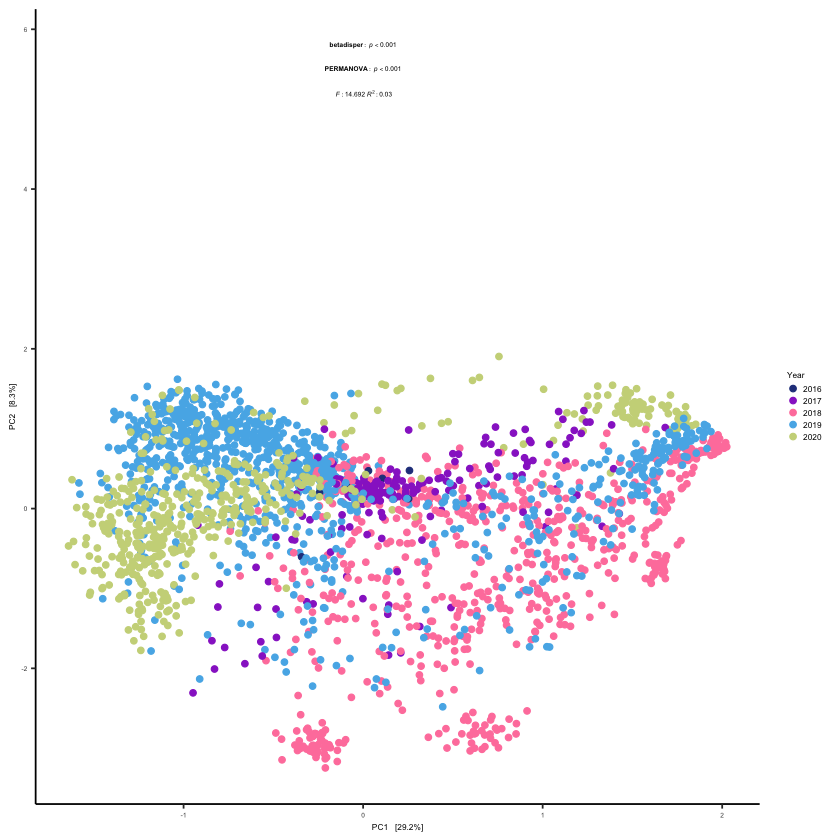

In [33]:
ord_year = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="collection_year",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
labs(color='Year') +
theme(legend.key.size = unit(.5, 'lines')) +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):14.692~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) +

scale_color_manual(values=c("royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_year


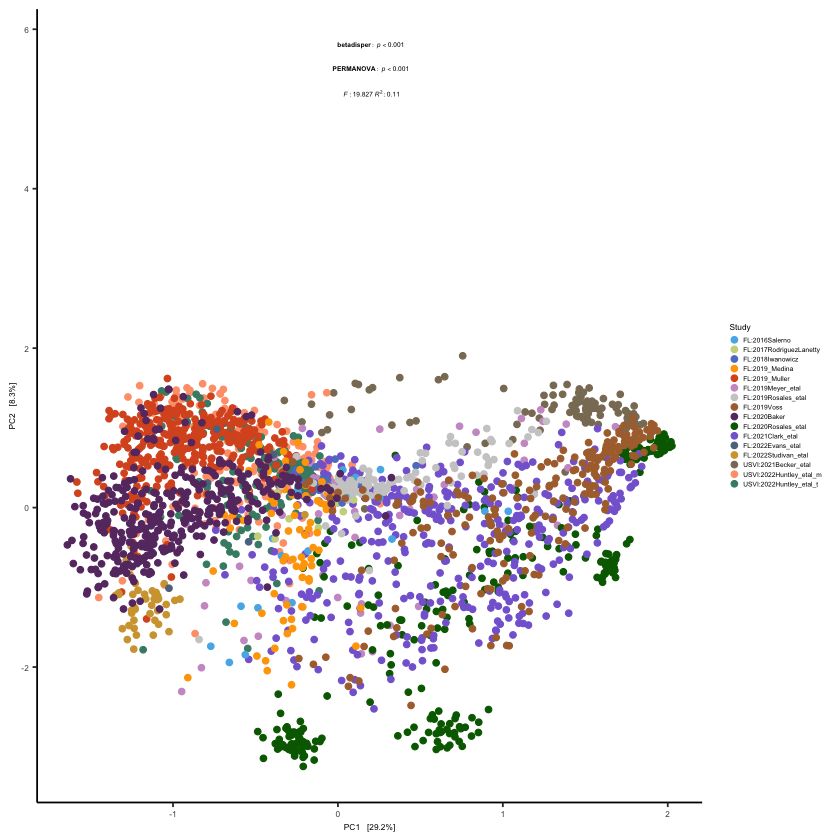

In [34]:
ord_alias= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Study",
                        
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
 theme(legend.key.size = unit(.4, 'lines')) +
labs(color='Study') +
annotate(geom="text", x=0.2, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.2, label = "~italic(F):19.827~italic(R^2):0.11",
           parse = TRUE, 
      
              color="black", size=1.4) +

scale_color_manual(values=c("#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD",
                           "gray80", "#AD6F3B", "#673770","#006700","#8569D5", 
                           "#5E738F","#D1A33D", "#8A7C64","lightsalmon","aquamarine4", "#652926",
                           "lightblue4", "lightpink","royalblue4","#D14285",
                           "palevioletred1", "#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_alias

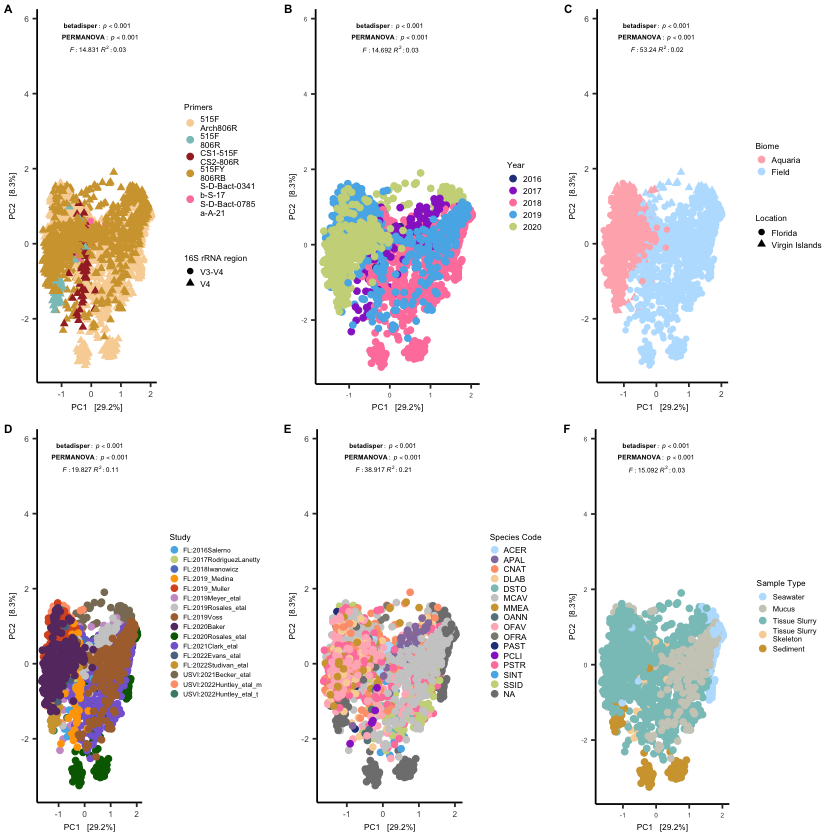

In [35]:
ggpubr::ggarrange(ord_primer, ord_year, ord_biome,
                 ord_alias, ord_species, ord_type,
                  labels = c("A", "B", "C", "D","E", "F"
                             #,"G"
                 )
                , font.label = list(size = 7, color = "black"))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure3.pdf",
     width = 6.8, height = 4.5, units = "in", dpi=300)

## Figure 4

In [36]:
# load library
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [37]:
#import DEICODE matrix
ord_Aq<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_A.qza")
ord_both<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_B.qza")
ord_Fi<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_F.qza")

In [38]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

In [39]:
ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples2 & Alias!="AcroporaDisease"
                       )

ps.coral

ps.coral_TL_reef =subset_samples(ps.coral, Biome=="Field")
ps.coral_TL_reef
                 
ps.coral_TL_meso =subset_samples(ps.coral, Biome=="Aquaria")
ps.coral_TL_meso

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

In [40]:
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral
  
ps.coral_TL_reef = filter_taxa(ps.coral_TL_reef, function(x) sum(x > 5 ) > (0.20*length(x)), TRUE)
ps.coral_TL_reef
                          
ps.coral_TL_meso = filter_taxa(ps.coral_TL_meso, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral_TL_meso

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 204 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 204 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 292 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 292 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 253 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 253 taxa by 10 taxonomic ranks ]

In [41]:
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')
ps.coral_TL_reef_CLR <- microbiome::transform(ps.coral_TL_reef, 'clr')
ps.coral_TL_meso_CLR <- microbiome::transform(ps.coral_TL_meso, 'clr')

ps.coral_clr.ord <- ordinate(ps.coral_clr, "RDA", "euclidean")
ps.coral_TL_meso_ord <- ordinate(ps.coral_TL_meso_CLR, "RDA", "euclidean")
ps.coral_TL_reef_ord <- ordinate(ps.coral_TL_reef_CLR, "RDA", "euclidean")

Joining, by = "SampleID"
Joining, by = "SampleID"


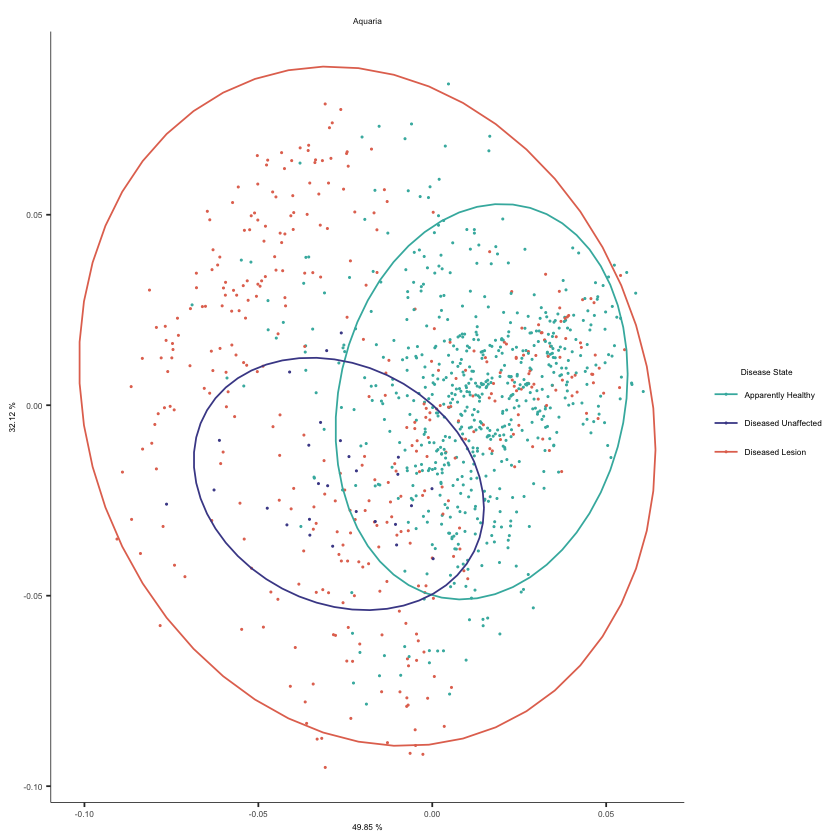

Joining, by = "SampleID"


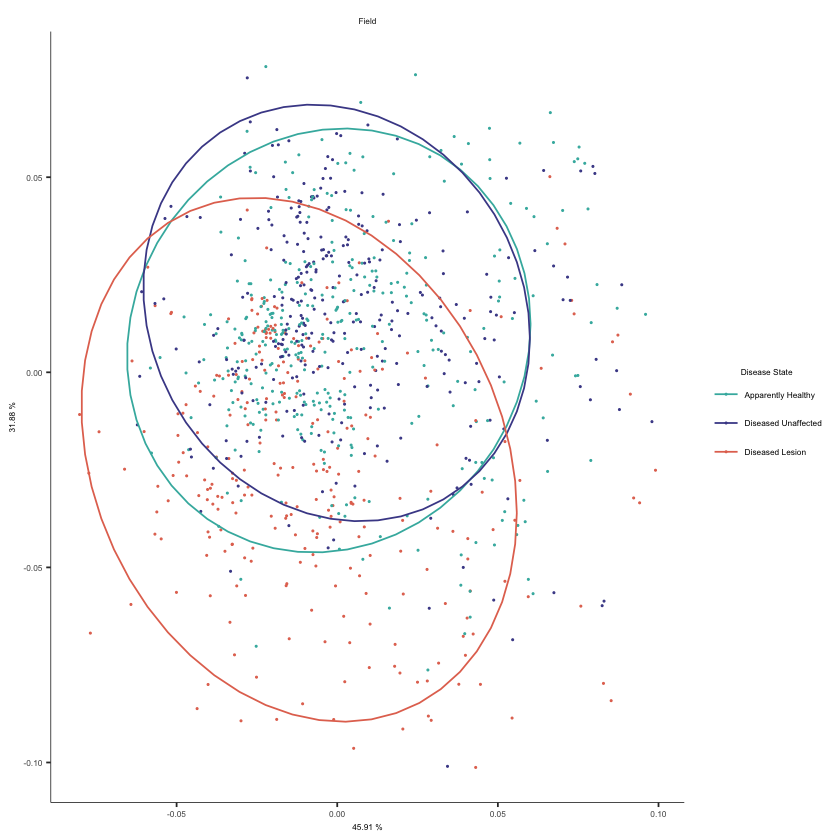

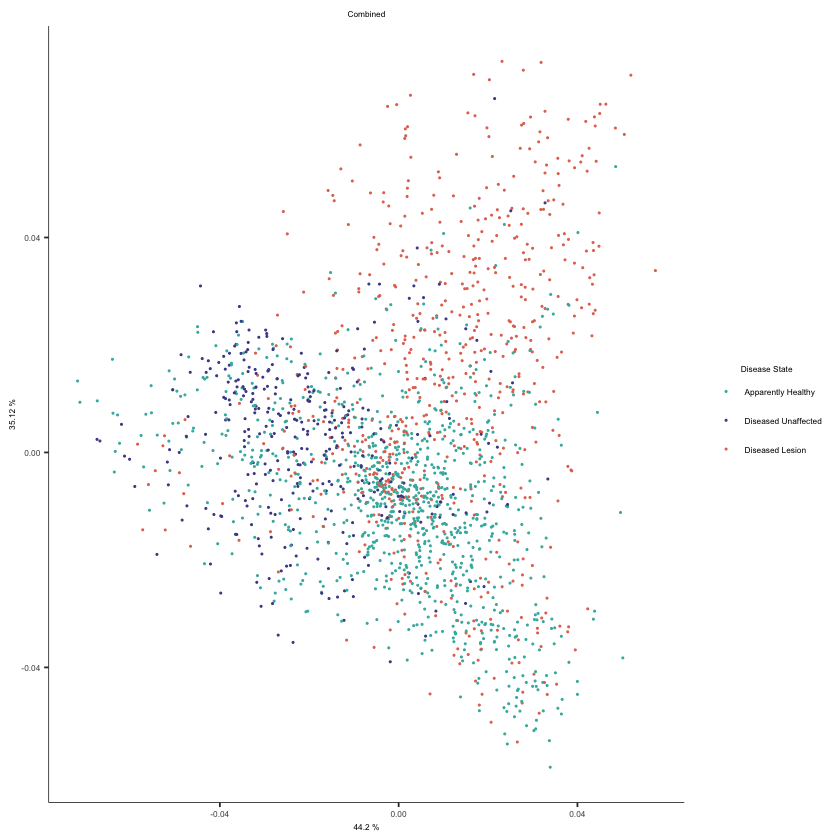

In [42]:
library(data.table)
sample_info_tab_16S$tissue_type <- factor(sample_info_tab_16S$tissue_type, 
    levels = c("AH", "DU", "DL"))

fig_aquria= ord_Aq$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_Aq$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Aq$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
labs(color="Disease State") +
theme(
     axis.line.y = element_line(size = .2), axis.line.x = element_line(size = .2)) +
facet_grid(.~Biome) +
guides(color = guide_legend(title.position = "top", 
                              title.hjust = 0.5)) 

fig_aquria



fig_field=ord_Fi$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_Fi$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Fi$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
facet_grid(.~Biome) +
labs(color="Disease State") +
theme(
     axis.line.y = element_line(size = .2), axis.line.x = element_line(size = .2)) +
guides(color = guide_legend(title.position = "top", 
                              title.hjust = 0.5)) 

fig_field


fig_both=ord_both$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
#stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_both$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_both$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
labs(color="Disease State", title="Combined") +
theme(plot.title = element_text(hjust = 0.5, vjust=.04, size=5),
     axis.line.y = element_line(size = .2), axis.line.x = element_line(size = .2)) +
guides(color = guide_legend(title.position = "top", 
                              title.hjust = 0.5)) 

fig_both

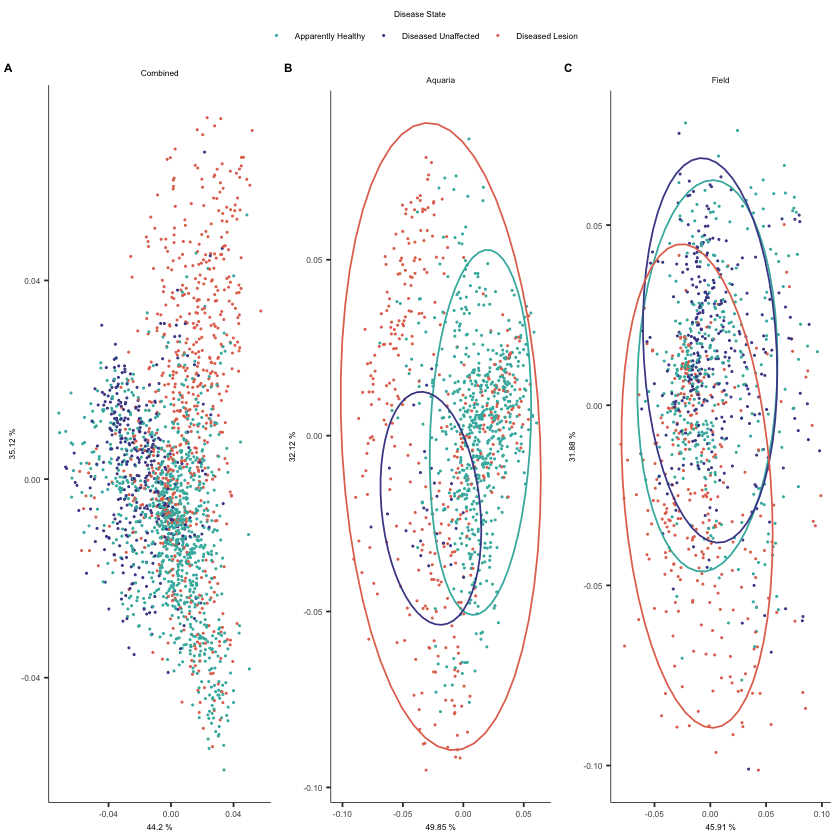

In [43]:
ggpubr::ggarrange(fig_both, fig_aquria, fig_field, labels = c("A", "B", "C"), common.legend = TRUE, 
                  font.label = list(size = 7, color = "black"), nrow =1)

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure4.pdf",
     width = 5, height = 4, units = "in", dpi=300)

## Figures 5 and 6

In [44]:
ps.coral.TS =subset_samples(physeq_16S, sample_type == "TissueSlurry" &
                        Alias !="AcroporaDisease")
ps.coral.TS
                          
ps.coral.TS = filter_taxa(ps.coral.TS, function(x) sum(x > 5) > (0.30*length(x)), TRUE)
ps.coral.TS  
                          
ps.coral.TSS =subset_samples(physeq_16S, sample_type == "TissueSlurry_Skeleton" &
                        Alias !="AcroporaDisease")
ps.coral.TSS
                          
ps.coral.TSS = filter_taxa(ps.coral.TSS, function(x) sum(x > 3) > (0.30*length(x)), TRUE)
ps.coral.TSS                          

ps.coral.M = subset_samples(physeq_16S, sample_type == "Mucus" &
                        Alias !="AcroporaDisease")
ps.coral.M

                           
ps.coral.M = filter_taxa(ps.coral.M, function(x) sum(x > 5) > (0.30*length(x)), TRUE)
ps.coral.M

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 1491 samples ]
sample_data() Sample Data:       [ 1491 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 102 taxa and 1491 samples ]
sample_data() Sample Data:       [ 1491 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 102 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 53 samples ]
sample_data() Sample Data:       [ 53 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 37 taxa and 53 samples ]
sample_data() Sample Data:       [ 53 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 37 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119455 taxa and 393 samples ]
sample_data() Sample Data:       [ 393 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 119455 taxa by 10 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 86 taxa and 393 samples ]
sample_data() Sample Data:       [ 393 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 86 taxa by 10 taxonomic ranks ]

In [45]:
out = ancombc(phyloseq = ps.coral.TSS, formula = "tissue_type", 
              p_adj_method = "fdr", zero_cut = 0.90, lib_cut = 100, 
              group ="tissue_type" , struc_zero = TRUE, neg_lb = FALSE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.001, global = TRUE)

res = out$res
res_global = out$res_global

In [46]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")


df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDU, tissue_typeDUSD)%>%
  mutate(group = ifelse(tissue_typeDU > 0, "DU", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)




sigs=res$diff_abn %>% as.data.frame() %>%
select(tissue_typeDL)  %>%
filter(tissue_typeDL=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDL)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)

df_fig_SS_DU = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% filter(tissue_typeDU > 1.5 | tissue_typeDU < -1.5)  %>%
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Tissue Slurry Skeleton")
df_fig_SS_DU 

Feature.ID                       tissue_typeDU tissue_typeDUSD group
1 69b9e715eb00d1c523dc38a57e7b8f05 -2.639841     0.8577884       AH   
  Kingdom     Phylum             Class                   Order              
1 d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria  o__Burkholderiales
  Taxa                                                     Family            
1  o__Burkholderiales_ f__Alcaligenaceae_ g__Achromobacter  f__Alcaligenaceae
  Genus             Species Consensus ASVs      Sig  Compartment           
1  g__Achromobacter NA      1         ASV_60577 TRUE Tissue Slurry Skeleton

In [47]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
 rownames_to_column("Feature.ID")


df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDL, tissue_typeDLSD)%>%
  mutate(group = ifelse(tissue_typeDL > 0, "DL", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)




sigs=res$diff_abn %>% as.data.frame() %>%
select(tissue_typeDL)  %>%
filter(tissue_typeDL=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDL)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)


df_fig_SS = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% 
filter(tissue_typeDL > 1.5 | tissue_typeDL < -1.5)  %>% 
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Tissue Slurry Skeleton")

df_fig_SS

Feature.ID                       tissue_typeDL tissue_typeDLSD group
1 24712789d715449daaa27de29528a23e -2.749689     0.7162627       AH   
2 69b9e715eb00d1c523dc38a57e7b8f05  2.018663     1.4880079       DL   
  Kingdom     Phylum             Class                   Order               
1 d__Archaea   p__Crenarchaeota   c__Nitrososphaeria      o__Nitrosopumilales
2 d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria  o__Burkholderiales 
  Taxa                                                                    
1  o__Nitrosopumilales_ f__Nitrosopumilaceae_ g__Candidatus_Nitrosopumilus
2  o__Burkholderiales_ f__Alcaligenaceae_ g__Achromobacter                
  Family                Genus                         Species                
1  f__Nitrosopumilaceae  g__Candidatus_Nitrosopumilus  s__uncultured_archaeon
2  f__Alcaligenaceae     g__Achromobacter             NA                     
  Consensus ASVs      Sig  Compartment           
1 0.6666667 ASV_21132 TRUE Tissue Slurry Skeleton
2 1.0000000 ASV_60577 TRUE Tissue Slurry Skeleton

In [48]:
ps_sigs_SS=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_SS) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
ps_sigs_SS


ps_sigs_SS_DU=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_SS_DU) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
ps_sigs_SS_DU

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 2 taxa by 15 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 1 taxa by 15 taxonomic ranks ]

In [49]:
out = ancombc(phyloseq = ps.coral.TS, formula = "tissue_type", 
              p_adj_method = "fdr", zero_cut = 0.90, lib_cut = 100, 
              group ="tissue_type" , struc_zero = TRUE, neg_lb = FALSE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.001, global = TRUE)

res = out$res
res_global = out$res_global

In [50]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")


df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDL, tissue_typeDLSD)%>%
  mutate(group = ifelse(tissue_typeDL > 0, "DL", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)


sigs=res$diff_abn %>% as.data.frame() %>%
select(tissue_typeDL)  %>%
filter(tissue_typeDL=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDL)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)


df_fig_TS = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% 
filter(tissue_typeDL > 1.5 | tissue_typeDL < -1.5) %>%
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Tissue Slurry")
head(df_fig_TS, n=2)

Feature.ID                       tissue_typeDL tissue_typeDLSD group
1 944c108b6e81ffecad1fda219fbe53f9 -5.032948     0.2036784       AH   
2 b12f1ebb5d05e1c88a9f265adb80fc55  9.749459     0.1779336       DL   
  Kingdom     Phylum             Class                   Order          
1 d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria  o__Ga0077536  
2 d__Bacteria  p__Proteobacteria  c__Alphaproteobacteria  o__Rhizobiales
  Taxa                                               Family          
1  o__Ga0077536_ f__Ga0077536_ g__Ga0077536           f__Ga0077536   
2  o__Rhizobiales_ f__Rhizobiaceae_ g__Cohaesibacter  f__Rhizobiaceae
  Genus             Species                  Consensus ASVs       Sig 
1  g__Ga0077536      s__uncultured_bacterium 1.0000000 ASV_85339  TRUE
2  g__Cohaesibacter  s__uncultured_bacterium 0.6666667 ASV_101999 TRUE
  Compartment  
1 Tissue Slurry
2 Tissue Slurry

In [51]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")


df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDU, tissue_typeDUSD)%>%
  mutate(group = ifelse(tissue_typeDU > 0, "DU", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)



sigs=res$diff_abn %>% as.data.frame() %>%

select(tissue_typeDU)  %>%
filter(tissue_typeDU=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDU)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)

df_fig_TS_DU = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% filter(tissue_typeDU > 1.5 | tissue_typeDU < -1.5) %>% 
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Tissue Slurry")%>%
arrange(-tissue_typeDU)
head(df_fig_TS_DU, n=2)

Feature.ID                       tissue_typeDU tissue_typeDUSD group
1 5a958ad2674d21074729f85cef9bf4a2 20.03517      0.2146648       DU   
2 83cebf00aca1b32cb3aa9d066dcd9008 12.71229      0.2795857       DU   
  Kingdom     Phylum            Class              Order               
1 d__Bacteria  p__Cyanobacteria  c__Cyanobacteriia  o__Synechococcales 
2 d__Bacteria  p__Bacteroidota   c__Bacteroidia     o__Flavobacteriales
  Taxa                                                           
1  o__Synechococcales_ f__Cyanobiaceae_ g__Synechococcus_CC9902  
2  o__Flavobacteriales_ f__Flavobacteriaceae_ g__NS5_marine_group
  Family                Genus                    Species                      
1  f__Cyanobiaceae       g__Synechococcus_CC9902  s__unidentified_marine      
2  f__Flavobacteriaceae  g__NS5_marine_group      s__uncultured_Flavobacterium
  Consensus ASVs      Sig  Compartment  
1 0.6666667 ASV_52045 TRUE Tissue Slurry
2 0.6666667 ASV_75801 TRUE Tissue Slurry

In [52]:
ps_sigs_TS=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_TS) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))

ps_sigs_TS

ps_sigs_TS_DU=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_TS_DU) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))

ps_sigs_TS_DU

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 44 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 44 taxa by 15 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 55 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 55 taxa by 15 taxonomic ranks ]

In [53]:
out = ancombc(phyloseq = ps.coral.M, formula = "tissue_type", 
              p_adj_method = "fdr", zero_cut = 0.90, lib_cut = 100, 
              group ="tissue_type" , struc_zero = TRUE, neg_lb = FALSE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.001, global = TRUE)

res = out$res
res_global = out$res_global

In [54]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")

df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDL, tissue_typeDLSD)%>%
  mutate(group = ifelse(tissue_typeDL > 0, "DL", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)


sigs=res$diff_abn %>% as.data.frame() %>%
select(tissue_typeDL)  %>%
filter(tissue_typeDL=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDL)




df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)




df_fig_M = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% 
filter(tissue_typeDL > 1.5 | tissue_typeDL < -1.5) %>% 
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Mucus")

head(df_fig_M, n=2)

Feature.ID                       tissue_typeDL tissue_typeDLSD group
1 bde147c1764d6c0cc326d13b2168a95b 10.682469     0.3434200       DL   
2 8f021ce8e37ca3cc8345e2afd5207eec  9.594643     0.3849296       DL   
  Kingdom     Phylum             Class                   Order               
1 d__Bacteria  p__Bacteroidota    c__Bacteroidia          o__Flavobacteriales
2 d__Bacteria  p__Proteobacteria  c__Gammaproteobacteria  o__Alteromonadales 
  Taxa                                                     
1  o__Flavobacteriales_ f__Flavobacteriaceae_ g__uncultured
2  o__Alteromonadales_ f__Alteromonadaceae_ g__Alteromonas 
  Family                Genus           Species                    Consensus
1  f__Flavobacteriaceae  g__uncultured  NA                         1.0000000
2  f__Alteromonadaceae   g__Alteromonas  s__uncultured_Alteromonas 0.6666667
  ASVs       Sig  Compartment
1 ASV_109302 TRUE Mucus      
2 ASV_82221  TRUE Mucus

In [55]:
df_fig1 = data.frame(res$W * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")


df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("Feature.ID")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")


df_fig = df_fig1 %>% left_join(df_fig2, by = "Feature.ID") %>%
  transmute(Feature.ID, tissue_typeDU, tissue_typeDUSD)%>%
  mutate(group = ifelse(tissue_typeDU > 0, "DU", "AH"))
df_fig$Feature.ID = factor(df_fig$Feature.ID, levels = df_fig$Feature.ID)



sigs=res$diff_abn %>% as.data.frame() %>%
select(tissue_typeDU)  %>%
filter(tissue_typeDU=="TRUE") %>%
rownames_to_column("Feature.ID") %>%
rename(Sig=tissue_typeDU)


df_fig1 = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID") %>% unite("Taxa", Order:Genus, remove = FALSE)

df_fig_M_DU = df_fig %>% left_join(as.data.frame(taxtable_16S), by="Feature.ID") %>% 
inner_join(sigs,  by="Feature.ID")  %>% filter(tissue_typeDU > 1.5 | tissue_typeDU < -1.5)  %>%
unite("Taxa", Order:Genus, remove = FALSE) %>%
mutate(Compartment = "Mucus")
head(df_fig_TS_DU, n=2)

Feature.ID                       tissue_typeDU tissue_typeDUSD group
1 5a958ad2674d21074729f85cef9bf4a2 20.03517      0.2146648       DU   
2 83cebf00aca1b32cb3aa9d066dcd9008 12.71229      0.2795857       DU   
  Kingdom     Phylum            Class              Order               
1 d__Bacteria  p__Cyanobacteria  c__Cyanobacteriia  o__Synechococcales 
2 d__Bacteria  p__Bacteroidota   c__Bacteroidia     o__Flavobacteriales
  Taxa                                                           
1  o__Synechococcales_ f__Cyanobiaceae_ g__Synechococcus_CC9902  
2  o__Flavobacteriales_ f__Flavobacteriaceae_ g__NS5_marine_group
  Family                Genus                    Species                      
1  f__Cyanobiaceae       g__Synechococcus_CC9902  s__unidentified_marine      
2  f__Flavobacteriaceae  g__NS5_marine_group      s__uncultured_Flavobacterium
  Consensus ASVs      Sig  Compartment  
1 0.6666667 ASV_52045 TRUE Tissue Slurry
2 0.6666667 ASV_75801 TRUE Tissue Slurry

In [56]:
ps_sigs_M=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_M) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))

ps_sigs_M


ps_sigs_M_DU=phyloseq(otu_table(physeq_16S, taxa_are_rows= T),
tax_table(as.data.frame(df_fig_M_DU) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
ps_sigs_M_DU

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 33 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 33 taxa by 15 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 53 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 53 taxa by 15 taxonomic ranks ]

In [57]:
ps_merged_sigs = merge_phyloseq(ps_sigs_TS, ps_sigs_SS, ps_sigs_M)
ps_merged_sigs

ps_merged_sigs_DU = merge_phyloseq(ps_sigs_TS_DU, ps_sigs_SS_DU, ps_sigs_M_DU)
ps_merged_sigs_DU

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 67 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 67 taxa by 15 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 91 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 91 taxa by 15 taxonomic ranks ]

In [58]:
bind_sigs_DU = bind_rows(df_fig_TS_DU, df_fig_M_DU, df_fig_SS_DU)
bind_sigs = bind_rows(df_fig_TS, df_fig_M, df_fig_SS)


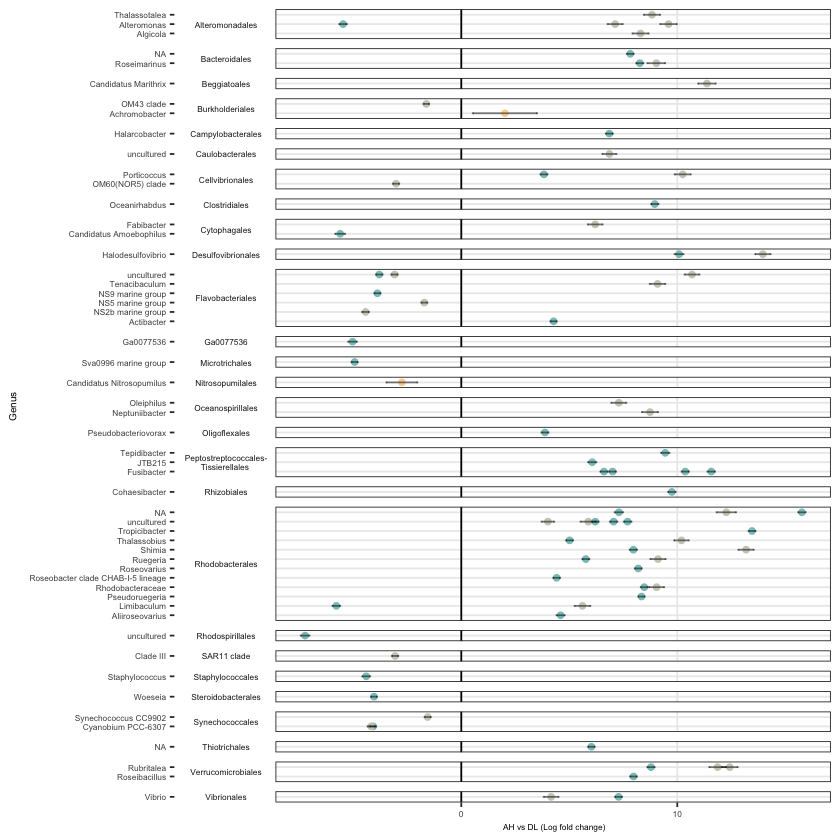

In [59]:
fig_sigs_DL = as.data.frame(bind_sigs) %>%
filter(Order!="NA") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%
ggplot( 
           aes(tissue_typeDL, y = Genus)
              ) + 
geom_point(aes(color=Compartment)) +
 
  theme_bw() + 
 theme(legend.position = "none",
      panel.grid.minor.x = element_blank()) +
  
geom_errorbar(aes(xmin = tissue_typeDL - tissue_typeDLSD, xmax = tissue_typeDL + tissue_typeDLSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
   labs(x = " AH vs DL (Log fold change)", y = "Genus") +  
scale_color_manual(values=c(
 "ivory3", "#89C4C2",  "#F9D4A4"
)) +
theme(axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 6),
    axis.text.x = element_text(size =5),
    axis.text.y = element_text(size =5)) +                            
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.text.y = element_text(size =5)) +                            
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
geom_vline(xintercept = 0,  color = "black", size=.5)

fig_sigs_DL


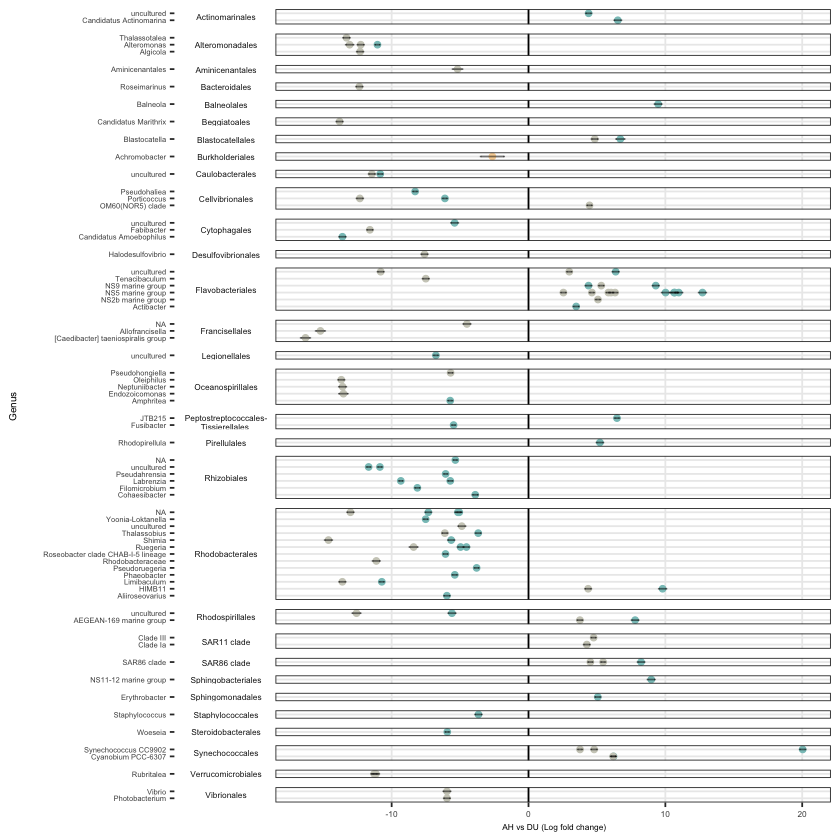

In [60]:
fig_sigs_DU = as.data.frame(bind_sigs_DU) %>%
filter(Order!="NA") %>%
filter(Order!="NA") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%

ggplot( 
           aes(tissue_typeDU, y = Genus)
              ) + 
geom_point(aes(color=Compartment)) +

  theme_bw() + 
 theme(legend.position = "none",
       panel.grid.minor.x = element_blank()) +
  
  
geom_errorbar(aes(xmin = tissue_typeDU - tissue_typeDUSD, 
                  xmax = tissue_typeDU + tissue_typeDUSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
  labs(x = " AH vs DU (Log fold change)", y = "Genus") + 
scale_color_manual(values=c(
 "ivory3", "#89C4C2",  "#F9D4A4"
)) +
theme(axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 6),
    axis.text.x = element_text(size =5),
    axis.text.y = element_text(size =4.5)) +                            
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.text.y = element_text(size =5)) +                            
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
geom_vline(xintercept = 0,  color = "black", size=.5)

fig_sigs_DU 

In [61]:


sigs_melt_DU = ps_merged_sigs_DU %>%
microbiome::transform("compositional") %>%
psmelt()    


sigs_melt_DL = ps_merged_sigs %>%
microbiome::transform("compositional") %>%
psmelt() 

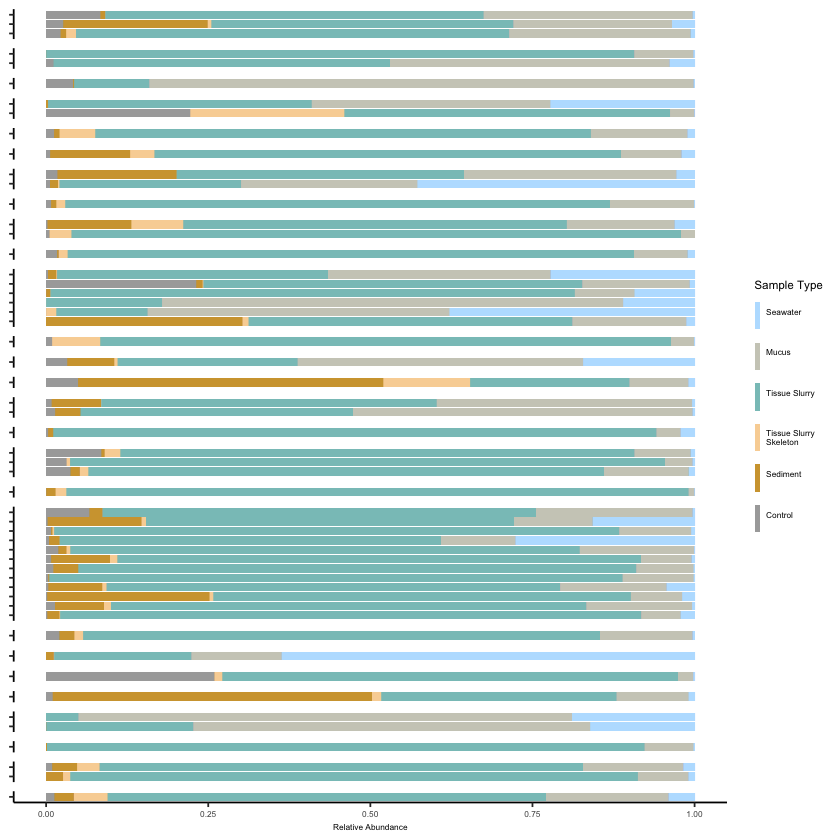

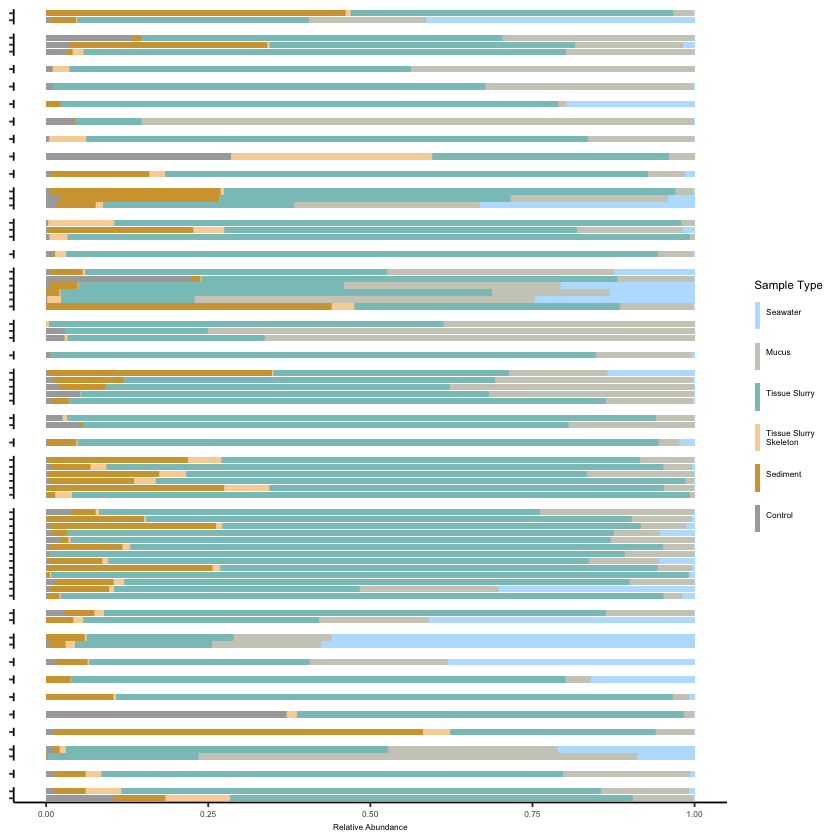

In [62]:
sigs_melt_DL$sample_type <- as.character(sigs_melt_DL$sample_type)
sigs_melt_DL$sample_type[is.na(sigs_melt_DL$sample_type)] <- "Control"

sigs_melt_DL$sample_type <- factor(sigs_melt_DL$sample_type, 
    levels = c("Seawater", "Mucus", "TissueSlurry", "TissueSlurry_Skeleton", "Sediment", "Control"))
                             



type_ra_DL = sigs_melt_DL %>%
filter(Order!="NA") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
ggplot( 
           aes(x = Abundance, y = Genus, fill=sample_type)
              ) + 
  geom_bar(stat = "identity",position="fill") +
theme_classic() +
scale_fill_manual(values=c("#bae1ff","ivory3", "#89C4C2", "#F9D4A4" , "#D1A33D", "Darkgrey"),
                label=c(TissueSlurry_Skeleton= "Tissue Slurry\nSkeleton",
                        TissueSlurry="Tissue Slurry\n",
                        Sediment="Sediment\n",
                        Seawater="Seawater\n",
                        Mucus="Mucus\n", 
                       Control="Control\n")) +
  labs(y = "ASVs", x = "Relative Abundance", fill = "Sample Type") + 
theme(strip.background = element_rect(fill="white")) +
theme(axis.title.y = element_blank(),
      axis.title.x = element_text(size = 5),
      axis.text.y = element_blank(),
      axis.text.x = element_text(size =5)) +

theme(strip.text.y = element_blank()) +
facet_grid(Order~., space ="free", scales="free", switch = "y") +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.35, ncol=1)) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=7)) +
theme(legend.spacing.y = unit(0.25, 'cm'))  +
  guides(fill = guide_legend(byrow = TRUE, keywidth = .25)) #+
#guides(fill = guide_legend(keywidth = 1, , keyheight =.25, ncol=1))


type_ra_DL

sigs_melt_DU$sample_type <- as.character(sigs_melt_DU$sample_type)
sigs_melt_DU$sample_type[is.na(sigs_melt_DU$sample_type)] <- "Control"

sigs_melt_DU$sample_type <- factor(sigs_melt_DU$sample_type, 
    levels = c("Seawater", "Mucus", "TissueSlurry", "TissueSlurry_Skeleton", "Sediment", "Control"))

type_ra_DU = sigs_melt_DU %>%
#filter(tissue_typeDU > 1.5 | tissue_typeDU < -1.5) %>%
filter(Order!="NA") %>%
#filter(sample_type %in% sub_samples) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
ggplot( 
           aes(x = Abundance, y = Genus, fill=sample_type)
              ) + 
 geom_bar(stat = "identity", position="fill") +
#, position = position_(width = 0.3)) +
  theme_classic()  +
scale_fill_manual(values=c("#bae1ff","ivory3", "#89C4C2", "#F9D4A4" , "#D1A33D", "Darkgrey"),
                label=c(TissueSlurry_Skeleton= "Tissue Slurry\nSkeleton",
                        TissueSlurry="Tissue Slurry\n",
                        Sediment="Sediment\n",
                        Seawater="Seawater\n",
                        Mucus="Mucus\n", 
                       Control="Control\n")) +
  labs(y = "ASVs", x = "Relative Abundance", fill = "Sample Type") + 
theme(strip.background = element_rect(fill="white")) +
theme(axis.title.y = element_blank(),
      axis.title.x = element_text(size = 5),
      axis.text.y = element_blank(),
      axis.text.x = element_text(size =5)) +

theme(strip.text.y = element_blank()) +
facet_grid(Order~., space ="free", scales="free", switch = "y") +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.35, ncol=1)) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=7)) +
theme(legend.spacing.y = unit(0.25, 'cm'))  +
  guides(fill = guide_legend(byrow = TRUE)) +
  guides(fill = guide_legend(byrow = TRUE, keywidth = .25))

type_ra_DU



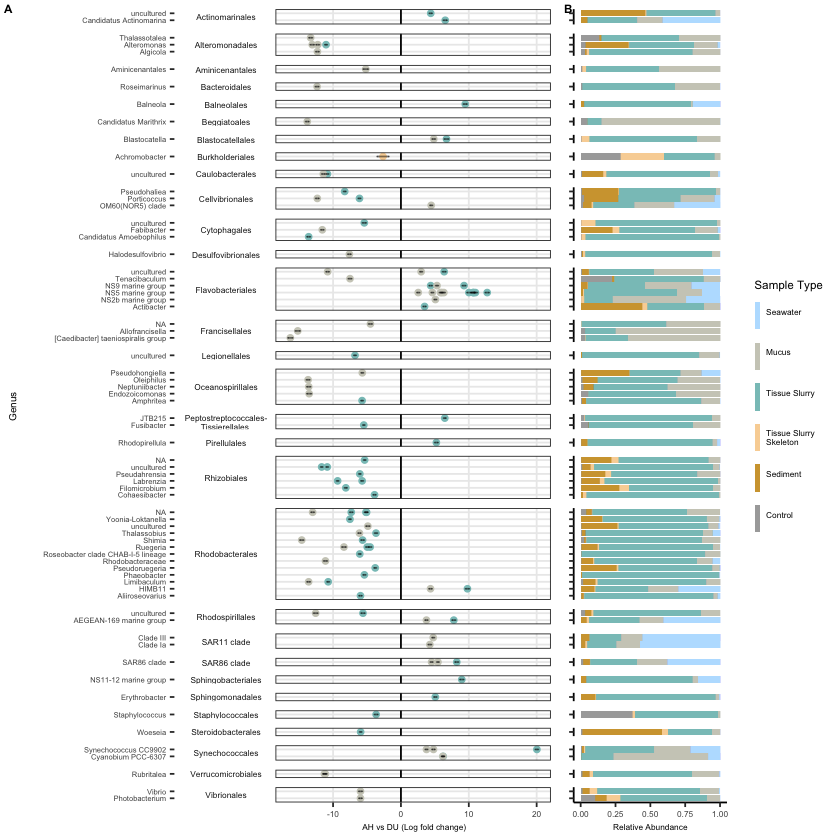

In [63]:
ggpubr::ggarrange(fig_sigs_DU,type_ra_DU, labels = c("A", "B"), nrow=1,
                  font.label = list(size = 7, color = "black"), widths = c(2, 1))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure5.pdf",
     width = 5.5, height = 6.7, units = "in", dpi=300)

Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


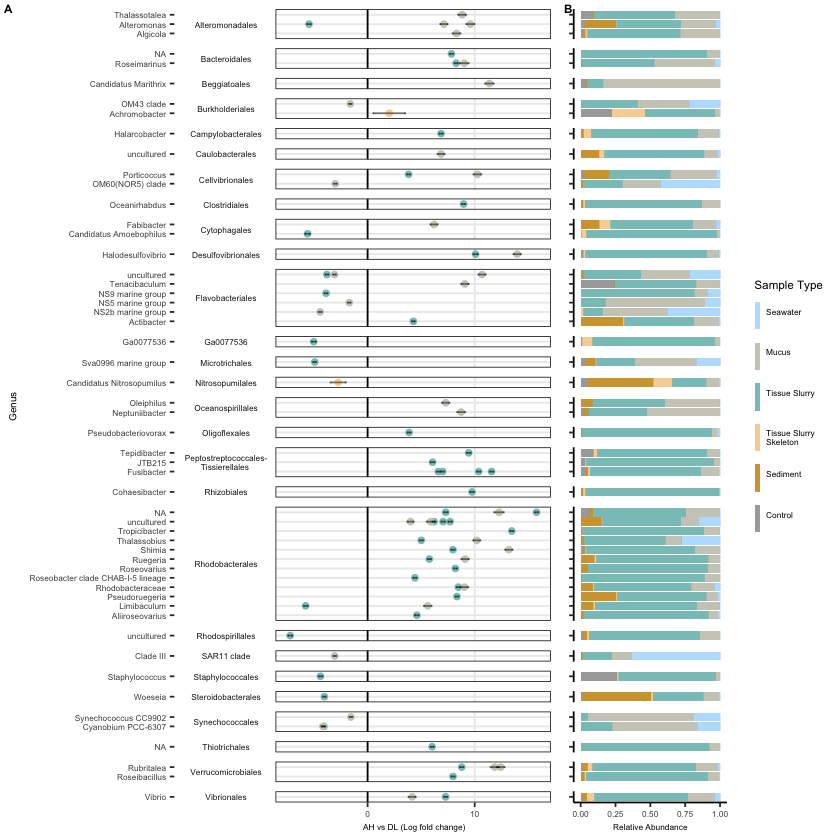

In [64]:
ggpubr::ggarrange(fig_sigs_DL,type_ra_DL, labels = c("A", "B"), nrow=1,
                  font.label = list(size = 7, color = "black"), widths = c(2, 1), align='hv')
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Figure6.pdf",
     width = 5.5, height = 6.2, units = "in", dpi=300)

## Supplemental 5 & 6

Warning message in `==.default`(sample_type, c("Sediment", "Seawater")):
“longer object length is not a multiple of shorter object length”
Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”
Warning message in `==.default`(sample_type, c("Sediment", "Seawater")):
“longer object length is not a multiple of shorter object length”
Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”
Warning message:
“Removed 148 rows containing missing values (geom_bar).”


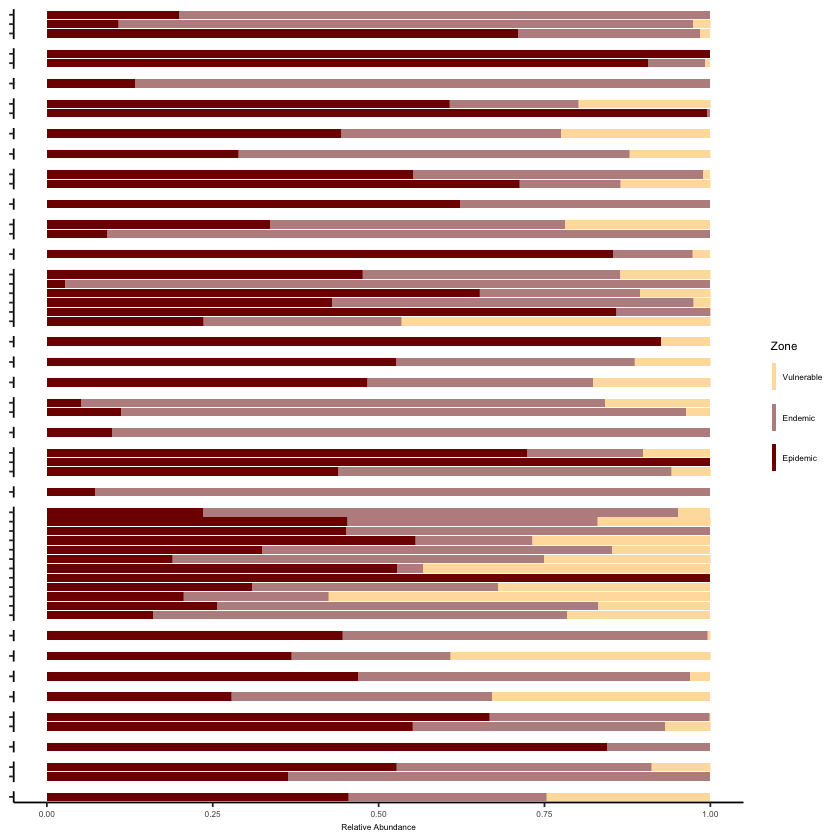

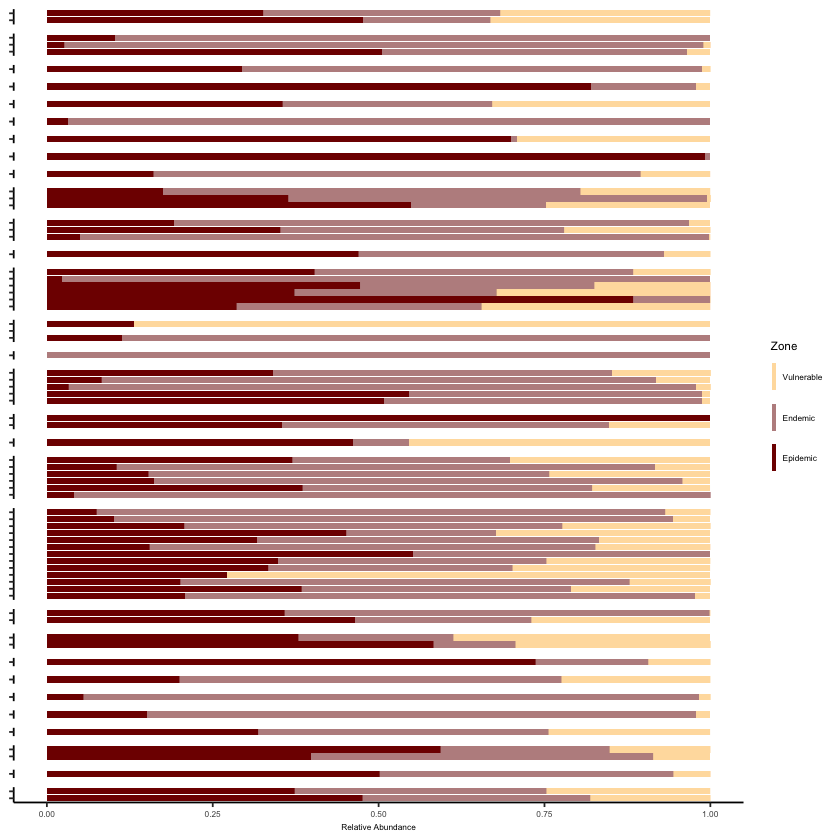

In [70]:

sigs_melt_DL$SCTLD_status <- factor(sigs_melt_DL$SCTLD_status, 
    levels = c("Vulnerable", "Endemic", "Epidemic"))


zone_ra_DL = sigs_melt_DL %>%
filter(Order!="NA") %>%
filter(SCTLD_status!="NA") %>%

filter(sample_type==c("Sediment", "Seawater")) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
ggplot( 
           aes(x = Abundance, y = Genus, fill=SCTLD_status)
              ) + 
  geom_bar(stat = "identity",position="fill") +
theme_classic() +
scale_fill_manual(values=c("#FFDEAD","#BC8F8F", "#800000")) +
  labs(y = "ASVs", x = "Relative Abundance", fill = "Zone") + 
theme(strip.background = element_rect(fill="white")) +
theme(axis.title.y = element_blank(),
      axis.title.x = element_text(size = 5),
      axis.text.y = element_blank(),
      axis.text.x = element_text(size =5)) +

theme(strip.text.y = element_blank()) +
facet_grid(Order~., space ="free", scales="free", switch = "y") +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.35, ncol=1)) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=7)) +
theme(legend.spacing.y = unit(0.25, 'cm'))  +
  guides(fill = guide_legend(byrow = TRUE, keywidth = .25)) #+
#guides(fill = guide_legend(keywidth = 1, , keyheight =.25, ncol=1))


zone_ra_DL

sigs_melt_DL$SCTLD_status <- factor(sigs_melt_DL$SCTLD_status, 
    levels = c("Vulnerable", "Endemic", "Epidemic"))

zone_ra_DU = sigs_melt_DU %>%
#filter(tissue_typeDU > 1.5 | tissue_typeDU < -1.5) %>%
filter(Order!="NA") %>%
filter(SCTLD_status!="NA") %>%
#filter(sample_type %in% sub_samples) %>%
filter(sample_type==c("Sediment", "Seawater")) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
ggplot( 
           aes(x = Abundance, y = Genus, fill=SCTLD_status)
              ) + 
 geom_bar(stat = "identity", position="fill") +
#, position = position_(width = 0.3)) +
  theme_classic()  +
scale_fill_manual(values=c("#FFDEAD","#BC8F8F", "#800000"),
                 label=c(TissueSlurry_Skeleton= "Tissue Slurry\nSkeleton",
                        TissueSlurry="Tissue Slurry\n",
                        Sediment="Sediment\n",
                        Seawater="Seawater\n",
                       Mucus="Mucus\n")) +
  labs(y = "ASVs", x = "Relative Abundance", fill = "Zone") + 
theme(strip.background = element_rect(fill="white")) +
theme(axis.title.y = element_blank(),
      axis.title.x = element_text(size = 5),
      axis.text.y = element_blank(),
      axis.text.x = element_text(size =5)) +

theme(strip.text.y = element_blank()) +
facet_grid(Order~., space ="free", scales="free", switch = "y") +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.35, ncol=1)) +
theme(legend.text =element_text(size=5),
      legend.title = element_text(size=7)) +
theme(legend.spacing.y = unit(0.25, 'cm'))  +
  guides(fill = guide_legend(byrow = TRUE)) +
  guides(fill = guide_legend(byrow = TRUE, keywidth = .25))

zone_ra_DU



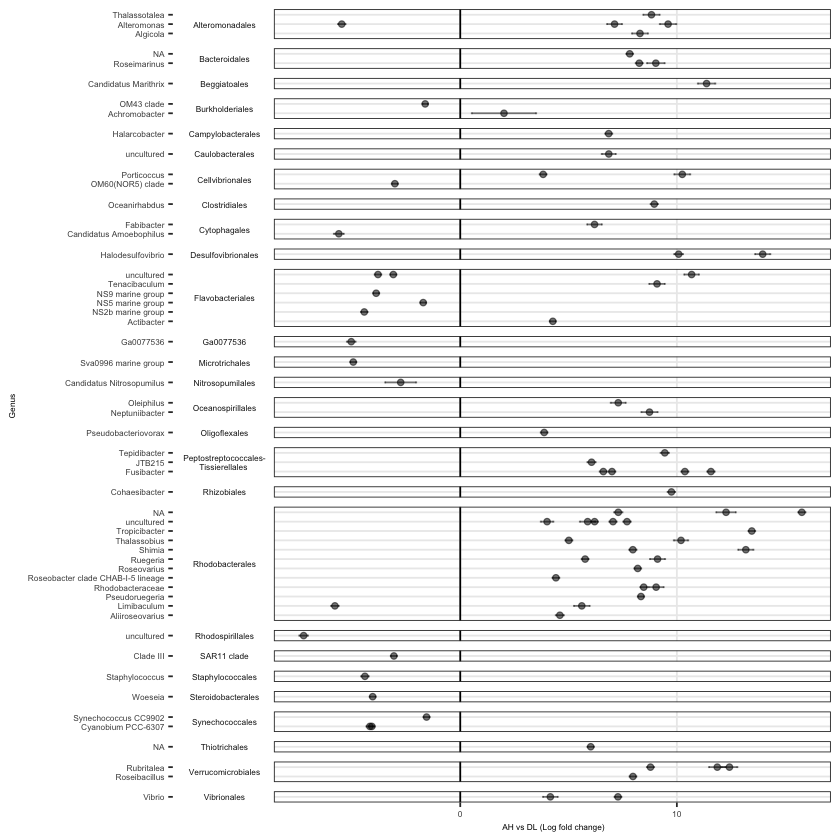

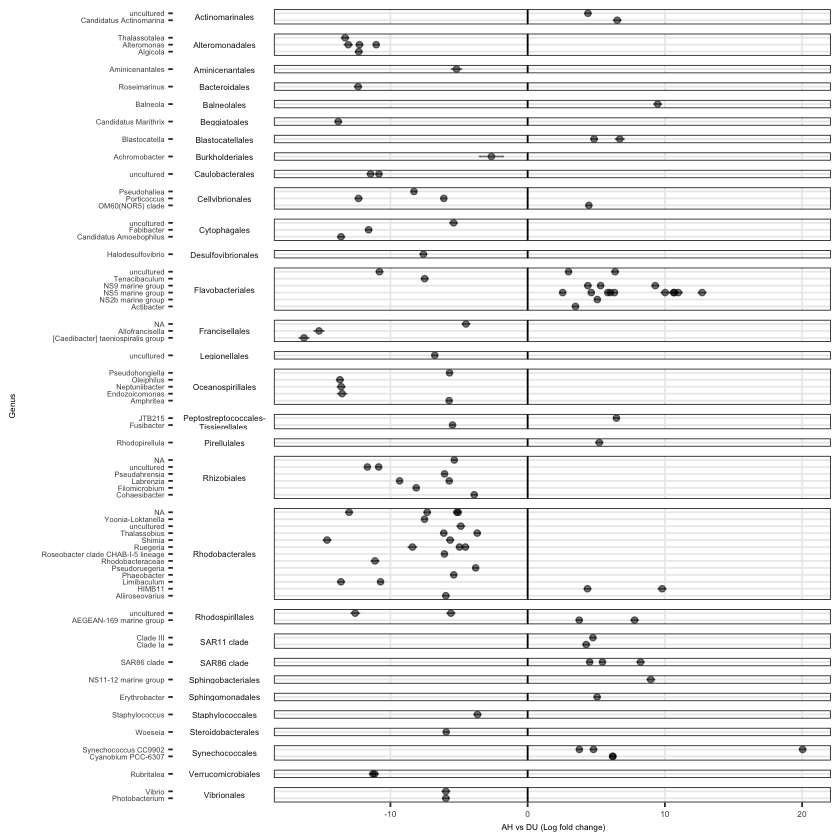

In [66]:
fig_sigs_DL_zone = as.data.frame(bind_sigs) %>%
filter(Order!="NA") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%
ggplot( 
           aes(tissue_typeDL, y = Genus)
              ) + 
geom_point(aes(alpha=0.4))  +
 
  theme_bw() + 
 theme(legend.position = "none",
      panel.grid.minor.x = element_blank()) +
  
geom_errorbar(aes(xmin = tissue_typeDL - tissue_typeDLSD, xmax = tissue_typeDL + tissue_typeDLSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
   labs(x = " AH vs DL (Log fold change)", y = "Genus") +  
scale_color_manual(values=c(
 "ivory3", "#89C4C2",  "#F9D4A4"
)) +
theme(axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_text(size =5),
    axis.text.y = element_text(size =5)) +                            
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.text.y = element_text(size =5)) +                            
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
geom_vline(xintercept = 0,  color = "black", size=.5)

fig_sigs_DL_zone



fig_sigs_DU_zone = as.data.frame(bind_sigs_DU) %>%
filter(Order!="NA") %>%
filter(Order!="NA") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%

ggplot( 
           aes(tissue_typeDU, y = Genus)
              ) + 
geom_point(aes(alpha=0.4)) +

  theme_bw() + 
 theme(legend.position = "none",
       panel.grid.minor.x = element_blank()) +
  
  
geom_errorbar(aes(xmin = tissue_typeDU - tissue_typeDUSD, 
                  xmax = tissue_typeDU + tissue_typeDUSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
  labs(x = " AH vs DU (Log fold change)", y = "Genus") + 
scale_color_manual(values=c(
 "ivory3", "#89C4C2",  "#F9D4A4"
)) +
theme(axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_text(size =5),
    axis.text.y = element_text(size =4.5)) +                            
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.text.y = element_text(size =5)) +                            
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
geom_vline(xintercept = 0,  color = "black", size=.5)

fig_sigs_DU_zone 

Warning message:
“Removed 148 rows containing missing values (geom_bar).”


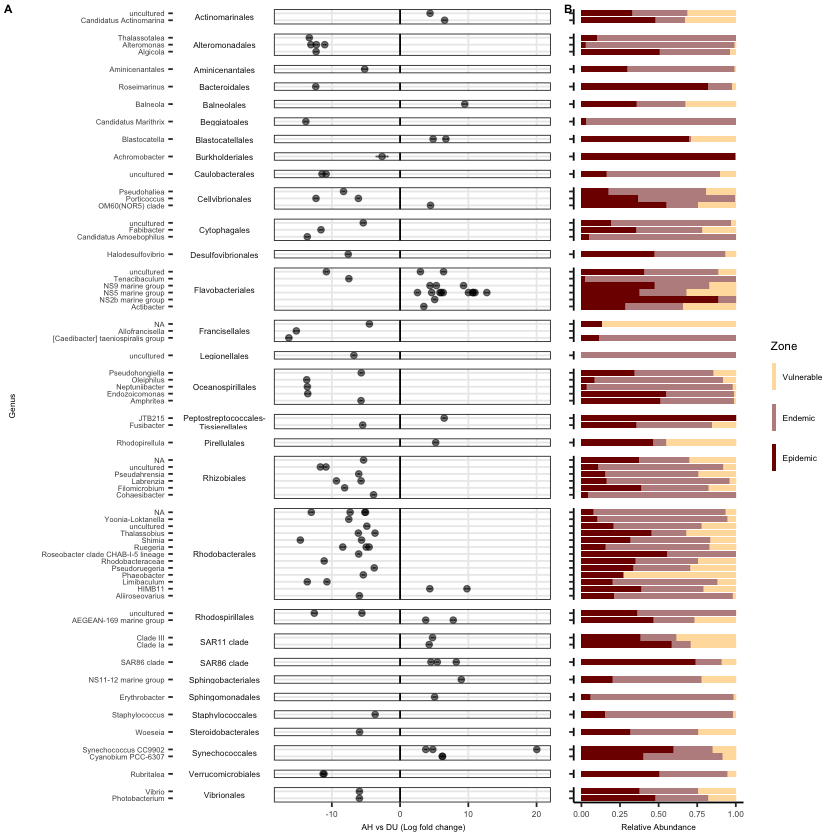

In [71]:
ggpubr::ggarrange(fig_sigs_DU_zone,zone_ra_DU, labels = c("A", "B"), nrow=1,
                  font.label = list(size = 7, color = "black"), widths = c(2, 1))


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/SupplementalFig5.pdf",
     width = 5.5, height = 6.7, units = "in", dpi=300)

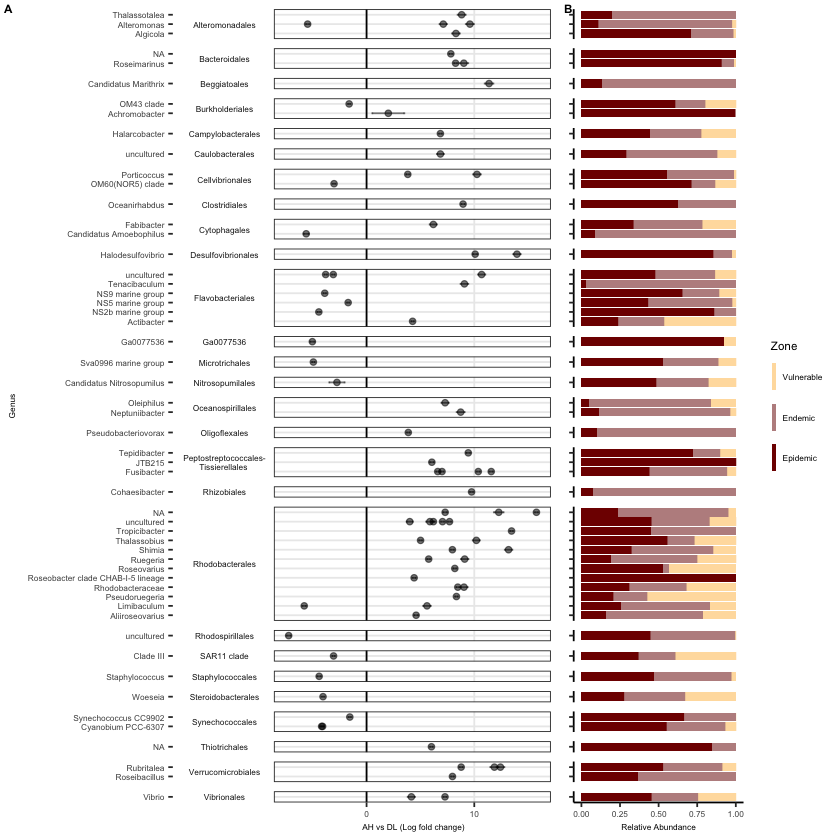

In [72]:
ggpubr::ggarrange(fig_sigs_DL_zone,zone_ra_DL, labels = c("A", "B"), nrow=1,
                  font.label = list(size = 7, color = "black"), widths = c(2, 1))


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/SupplementalFig6.pdf",
     width = 5.5, height = 6.2, units = "in", dpi=300)